# Seasonal forecasts of New Zealand's local climate conditions with limited GCM inputs using Convolutional Neural Networks

**Motivation**

GCM (global circulation model) rainfall and temperature predictions are of 1-degree spatial resolution, which is coarse on local (subgrid) scales. For example, the whole of New Zealand is represented by a few grid points. Downscaling seasonal forecasts help to have more precise predictions on smaller regions.

We are interested in the prediction of rainfall and temperature in 6 climate regions of New Zealand: North of the North Island (NNI), East of the North Island (ENI), West of the North Island (WNI), North of the South Island (NSI), East of the South Island (ESI) and West of the South Island (WSI).

A convolutional neural network (CNN) has been developed to predict temperature and rainfall for each region, where inputs to CNN are the outputs of GCM.

# Data

Data consists of GCM (ECMWF) outputs of 3 variables temperature 2m, geopotential height (850Hpa) and precipitation with a spatial extent of 0-359 degree (360 lines) longitude and 90S-90N (181 lines) latitude. There are a total of 181*360 grid points. 

The climatological mean of data is 1981 - 2010.

Temporal extent is monthly frequency from April 1981 to Dec 2019, therefore the data consist of a total of 465 instances.

This task is considered as a classification problem, so the target variables rainfall and temperature have been divided into quantiles with respect to the climatological mean. 

Quantiles labels are represented by 1 (<20%), 2 (20%-40%), 3 (40%-60%), 4 (60%-80%) and 5 (>80%) in the data. We represent Q1: (<20%), Q2: (20%-40%), Q3:(40%-60%), Q4: (60%-80%) and Q5 (>80%) in the confusion matrices.

GCM provide monthly averaged variables up to 6 months in the future. We only considered forecasts at 3 months lead-time, (e.g. forecasts for the period June-July-August initialised on the 1st of May).


**Data Split**

Data consist of 3 files of GCM outputs (CNN inputs) and 12 files of temperature and rainfall labels for each region (CNN target variables).  
 
Data are divided into training, validation and test sets. Training set consists of 324 instances (70% of the data, April 1981 - Mar 2008), the validation set consists of 71 instances (15% of the data, April  2008 - Feb 2014) and the test set consists of 70 instances (15% of the data, Mar  2014 - Dec  2019).



**Quadratic weighted kappa**

The quadratic weighted kappa(QWK) was used as an evaluation metric (k). An experiment was done using continuous quadratic weighted kappa as a loss function.

# To install optuna library

Optuna library is installed to import Optuna functions that will be used for hyperparameter tuning.

In [ ]:
pip install optuna

     |████████████████████████████████| 302 kB 7.4 MB/s 
     |████████████████████████████████| 164 kB 62.3 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 75 kB 5.0 MB/s 
     |████████████████████████████████| 111 kB 76.4 MB/s 
     |████████████████████████████████| 141 kB 90.4 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=52cb5d99bb4e00591c3d34d3ddfcf0da0818e6581127b30320d968b183bb4a88
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# Importing main packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch_optimizer as optim1
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import optuna
from sklearn.metrics import cohen_kappa_score, accuracy_score

import seaborn as sn

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GCM outputs
Data-preprocessing 

* Uploading 3 GCM variables such as temperature, precipitation and geo-potential height. Each variable file is 2-dimensional (465*65160).

* CNN accepts input of 4-dimensions  (batch_size, channels, height, weight).

* Converting each GCM variable into Pytorch tensors then reshaping their shape into 3- form with respect to the number of grid points of latitude and longitude (465 * 181 * 360).

* Normalising all tensors from 0 to 1 by creating a user-defined normalisation function.

* Stacking 3 GCM  variables as a channel of the input tensor (465 * 3 * 181 * 360). This represents inputs (X) to the CNN. 


In [ ]:
# Reading GCM precipitation file
precip1 = pd.read_csv('drive/MyDrive/DL_project/PRECIP_1981_2019_ECMWF.csv')

In [ ]:
precip1.head()

In [ ]:
# To check is there null value
precip2.isna().sum()

In [ ]:
#Reading GCM precipitation by removing first 3 rows 
precip = pd.read_csv("drive/My Drive/DL_project/PRECIP_1981_2019_ECMWF.csv", sep=",",skiprows=3,  header=None )


In [ ]:
# Dropping first column of dates
precip_drop = precip.drop(precip.columns[0], axis=1)

In [ ]:
precip_drop.shape

(465, 65160)

In [ ]:
# Reading GCM temp file by removing first 3 rows
t2m = pd.read_csv("drive/MyDrive/DL_project/T2M_1981_2019_ECMWF.csv", sep=",", skiprows=3, header=None)


In [ ]:
# Dropping first column of temp
t2m_drop = t2m.drop(t2m.columns[0], axis=1)
t2m_drop.shape

(465, 65160)

In [ ]:
# Reading GCM geo-potential height file by removing first 3 lines
z850 = pd.read_csv("drive/My Drive/DL_project/Z850_1981_2019_ECMWF.csv", sep=",", skiprows=3, header=None)


In [ ]:
# Dropping first column of geo-potential height
z850_drop = z850.drop(z850.columns[0], axis=1)
z850_drop.shape

(465, 65160)

## Plots

Converting precip, t2m and z850 variables values into Pytorch tensors and then their shape (size) from 2-dimension to 3-dimensions. Plotting for a single row of each variable. 

In [ ]:
# Converting GCM variables values to Pytorch tensors
precip1 = torch.as_tensor(precip_drop.values).type(torch.FloatTensor)
t2m1 = torch.as_tensor(t2m_drop.values).type(torch.FloatTensor)
z8501 = torch.as_tensor(z850_drop.values).type(torch.FloatTensor)

In [ ]:
#Unflattening GCM variabels (reshaping their size)
precip2 = precip1.reshape(465, 181, 360)
t2m2 = t2m1.reshape(465, 181, 360)
z8502 = z8501.reshape(465, 181, 360)


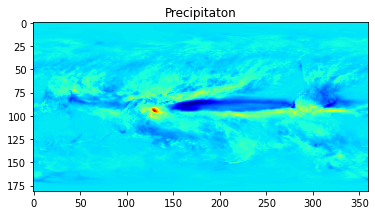

In [ ]:
# Plot first row of precip
plt.imshow(precip2[0], cmap='jet')
plt.title('Precipitaton');

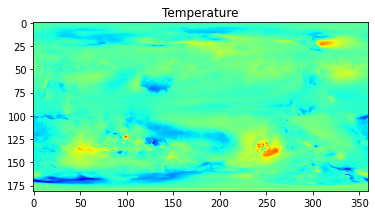

In [ ]:
# Plot first row of temp
plt.imshow(t2m2[0], cmap='jet')
plt.title('Temperature');

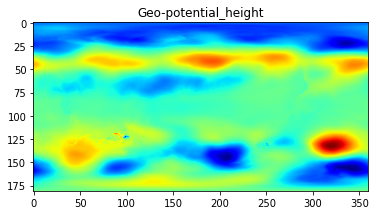

In [ ]:
# Plot first row of geo-potential height
plt.imshow(z8502[0], cmap='jet')
plt.title('Geo-potential_height');

The user-defined normalise function was used to normalise the values 0-1. Stacking GCM variables as the channel of the input tensor and convert tensors into 4-dimensional.

In [ ]:
# Normalising function

def norm_mean(a):


  for i in range(a.shape[0]):


     mu = torch.mean(a[i])
     std = torch.std(a[i])

     a[i] = (a[i] - mu)/std #implicit broadcasting applied on scalars

  return a   


In [ ]:
#normalising GCMs
precip3 = norm_mean(precip2)
t2m3 = norm_mean(t2m2)
z8503 = norm_mean(z8502)

In [ ]:
precip_norm.shape

torch.Size([465, 181, 360])

In [ ]:
# Stacking 3 GCM variables
dataTensor = torch.stack([precip3, t2m3, z8503], dim=1)

# CNN

CNN architecture setting:

Convolutional layers: 6 and 12 filters of 5x5 size, padding of 0 and stride of 1; Relu activation function.  Average pooling layers: stride 2. Fully-connected layers: 120 (Relu), 60 (Relu) and 5 (Softmax) neurons.

## Dropout CNN 0.5
CNN consists of a dropout of 0.5 to the fully connected layers. This CNN is used for the evaluation of the test dataset.

In [ ]:
# Building CNN network with dropouts

class Network_drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        #self.drop_out = nn.Dropout(p=0.5)
        
        #self.conv2_bn = nn.BatchNorm2d(12)
        
        self.fc1 = nn.Linear(in_features= 12*42*87, out_features=120)
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.drop_out = nn.Dropout(p=0.5)
        self.out = nn.Linear(in_features=60, out_features=5)
        #self.drop_out = nn.Dropout(p=0.5)
        

    def forward(self, t):
    # implement the forward pass
    
        # (1) input layer
        t = t #usually omitted since this is obviously trivial; size 360*131

        # (2) hidden conv layer
        t = self.conv1(t) #Haven't implemented wrapping - so after a 5x5 convolution, 
       
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
        
        #pooling 2x2 with stride 2 - reduces to 6 * 178 * 63

        # (3) hidden conv layer
        #t = self.conv2(t)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
        #t = self.drop_out(t)
       
        #pooling 2x2 with stride 2 - reduces to 12 * 29 * 87

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 42 * 87)
        t = self.fc1(t)
        #t = self.fc1_bn(self.fc1(t))
        t = F.relu(t)
        t = self.drop_out(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        t = self.drop_out(t)

        # (6) output layer
        t = self.out(t)
        #t = self.drop_out(t)
        
        #t = F.softmax(t, dim=1) #implicitly performed by F.cross_entropy()

        return t

## Dropout CNN

CNN consists of dropout to the fully connected layers. It is used for Optuna hyperparameter tuning.

In [ ]:
# Building CNN network with dropouts

class Network_dropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        #self.conv2_bn = nn.BatchNorm2d(12)
        
        self.fc1 = nn.Linear(in_features= 12*42*87, out_features=120)
        self.drop_out = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.drop_out = nn.Dropout(p=dropout)
        self.out = nn.Linear(in_features=60, out_features=5)
        #self.drop_out = nn.Dropout(p=0.5)
       

    def forward(self, t):
    # implement the forward pass
    
        # (1) input layer
        t = t #usually omitted since this is obviously trivial; size 360*131

        # (2) hidden conv layer
        t = self.conv1(t) #Haven't implemented wrapping - so after a 5x5 convolution, 
       
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
        
        #pooling 2x2 with stride 2 - reduces to 6 * 178 * 63

        # (3) hidden conv layer
        #t = self.conv2(t)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)
       
        #pooling 2x2 with stride 2 - reduces to 12 * 29 * 87

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 42 * 87)
        t = self.fc1(t)
        #t = self.fc1_bn(self.fc1(t))
        t = F.relu(t)
        t = self.drop_out(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        t = self.drop_out(t)

        # (6) output layer
        t = self.out(t)
        #t = self.drop_out(t)
        
        #t = F.softmax(t, dim=1) #implicitly performed by F.cross_entropy()

        return t

## CNN with batch normalisation

CNN consists of 2 convoutional layers followed by max pooling, 3 fully connected layers with batch normalisation.  A dropout of 0.5 is added to fully connected layers.

In [ ]:
# Building CNN network with dropouts

class Network_drop_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        #self.drop_out = nn.Dropout(p=0.5)
        
        
        
        self.fc1 = nn.Linear(in_features= 12 * 42 * 87, out_features=120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.conv2_bn = nn.BatchNorm2d(60)
        self.drop_out = nn.Dropout(p=0.5)
        self.out = nn.Linear(in_features=60, out_features=5)
       
        #they are dependant on the colour channels (3 since 3 GCMs) and output classes (5 since 5 classes on cat5) respectively

    def forward(self, t):
    # implement the forward pass
    
        # (1) input layer
        t = t #usually omitted since this is obviously trivial; size 360*131

        # (2) hidden conv layer
        t = self.conv1(t) #Haven't implemented wrapping - so after a 5x5 convolution, 
       
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #pooling 2x2 with stride 2 - reduces to 6 * 178 * 63

        # (3) hidden conv layer
        #t = self.conv2(t)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #t = self.drop_out(t)
       
        #pooling 2x2 with stride 2 - reduces to 12 * 29 * 87

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 42 * 87)
        t = self.fc1(t)
        t = self.fc1_bn(t)
        t = F.relu(t)
        t = self.drop_out(t)

        # (5) hidden linear layer
        t = self.fc2(t)
       # t = self.conv2_bn(t)
        t = F.relu(t)
        t = self.drop_out(t)

        # (6) output layer
        t = self.out(t)
        t = self.drop_out(t)
        
   
        #t = F.softmax(t, dim=1) #implicitly performed by F.cross_entropy()


        return t

# Rainfall models

## NNI region

In [ ]:
# Reading rainfall file of NNI region
Data_rain_NNI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_NNI_regional_ave_time_series.csv", sep=",")

In [ ]:
# Extracting quantiles labels from rainfall NNI data
Labels_rain_NNI = Data_rain_NNI['cat_5'].astype(int) 
Labels_rain_NNI

0      4
1      4
2      5
3      4
4      5
      ..
460    2
461    3
462    3
463    2
464    1
Name: cat_5, Length: 465, dtype: int64

## NNI Rainfall labels

NNI region quantiles labels are represented by 1, 2, 3, 4, 5 in the data set, but Pytorch accepts the labels from 0, 1, 2,3,4.

Converting NNI region rainfall labels into tensors and 0, 1, 2, 3, 4. This represents target variable Y.

In [ ]:
# Function to convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #labels in the form of 1, 2, 3, 4, 5;

# Converting labels of NNI region into tensors
labelsTensors_NNI = labels_Tensors(Labels_rain_NNI) # This represents y

In [ ]:
# Distribution of original NNI region rainfall labels
Labels_rain_NNI.value_counts()

1    104
3     96
2     91
5     88
4     86
Name: cat_5, dtype: int64

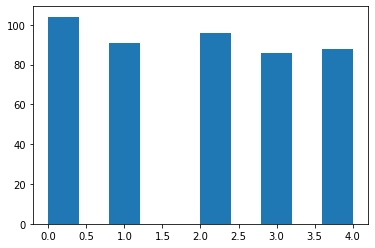

In [ ]:
# Histograms of original NNI region labels
plt.hist(labelsTensors);

## Training, validation and test split

Data are divided into training set with initial 324 data points (70% of data, April 1981 - Mar 2008), validation set is next 71 data ponits (15% of the data, April 2008 - Feb 2014) and test set is last 70 data points (last 15% of data, Mar 2014 - Dec 2019 ).

In [ ]:
# Spliting the dataTensors into training and test tensors 

train_Tensor = dataTensor[:324] # train set  
valid_Tensor = dataTensor[324:395]  # Valid set
test_Tensor = dataTensor[395:] # test set


In [ ]:
# Train lables distribution
Train_labels = Labels_rain_NNI[:324]
Train_labels.value_counts()

4    67
2    66
1    66
3    63
5    62
Name: cat_5, dtype: int64

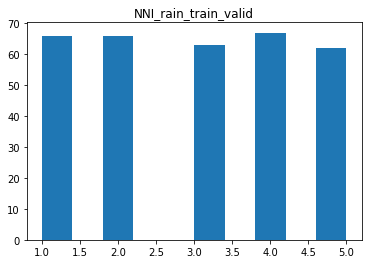

In [ ]:
# Histograms of train labels
plt.hist(Train_labels)
plt.title('NNI_rain_train_valid');

# Optuna

Optuna library was utilised for hyperparameter tuning. 
The set of values were assinged to hyperparameters as follows:
batch size: [1, 10], learning rate: {0.1, 0.01, 0.001, 0.0001}, optimizer: {Adam, SGD, RMSprop} and dropout rate: {0.5, 0.7, 0.8, 0.9}.  The dropouts were added to the fully-connected layers.


Steps to run the model under the Optuna framework:

* Function to create data loaders.
* Main function consists of the dictionary where all hyperparameter values are assigned, calling data loader function to have the training and validation data loaders, and a for loop that performs the training and validation steps. This function returns the validation accuracy to which we would like to maximize.
* Final step is to define the objective function and set the number of trials.

The best combination of hyperparameters that was determined for rainfall models are as follows:  batch size 10, learning rate 0.0001, RMSprops optimiser and 0.5 dropout rates.

Dataloader function

This function creates a training set and validation set by concatenating input values (X, GCM variables) and target values (y, rainfall dataset) like (X, y) form. Train loader and validation loader are created by using trainset and validation set.

In [ ]:
# Function to get data loader functions

def get_valid_loaders_NNI(Batch_size):
    """Get data loaders"""
    
    # Creating train set and validation set
    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NNI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NNI[325:395])
    # Creating train and validation dataloader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
    

    return train_loader, valid_loader

Optuna framework is based on study object. It contains all of the information about the required parameter space. Maximize is assigned to direction variable as we are keen to find the maximum validation accuracy.

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-08-25 23:06:09,268] A new study created in memory with name: no-name-2958f9fc-1003-4635-8524-b24433b77578


Main function:

Once the study is created, the search space is incorporated via the trial.suggest_ methods. We can define different configuration to each parameter in cfg dictionary of main function (here we have train_Rain function).  We have defined the values to hyperparameter as follows:
 batch size: [1, 10], learning rate: {0.1, 0.01, 0.001, 0.0001}, optimizer: {Adam, SGD, RMSprop} and dropout rate: {0.5, 0.7, 0.9}. 

This function has a for loop which performs training and validation steps and returns the validation accuracy.

 

In [ ]:
# Main function to run

def train_NNI(trial):
  
  cfg = { 
         'Batch_size' : trial.suggest_int('Batch_size', 1, 10),
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       : trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001]),          
          'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam, optim.RMSprop]),
          'dropout'       : trial.suggest_categorical('dropout', [0.5, 0.7,0.9 ]),
          'activation': F.relu}

  # Loss function is defined
  criterion = nn.CrossEntropyLoss()
  # Defining device to run experiments on GPU if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  # Calling dataloader function
  train_loader, valid_loader = get_valid_loaders_NNI(cfg['Batch_size'])
  # Defining CNN model
  model = Network_dropout(cfg['dropout']).to(device)
  # Setting optimizer
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
   
  # Training steps
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
     
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       
    
      
       
       for batch_idx, (data, target) in enumerate(train_loader):
           # Putting data and target on device to run on GPU 
           data, target = data.to(device), target.to(device)
           # making zero gradient
           optimizer.zero_grad()
           # predicting new values by inserting input
           output = model(data)
           # bring model output and target back on CPU
           output_c = output.cpu()
           target_c = target.cpu()
           # clculating loss
           loss =  criterion(output_c, target_c)
           # calculate gradient
           loss.backward()
           # update weights
           optimizer.step()
           #Storing training loss 
           train_loss += loss.item()
           # Calculating number of correct label predictions
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              # Putting data and target on device to run on GPU 
              data, target = data.to(device), target.to(device) 
              # predicting new values by inserting input        
              output = model(data)
              # bring model output and target back on CPU
              output_c = output.cpu()
              target_c = target.cpu()
              # clculating loss
              loss = criterion(output_c, target_c) 
              #Storing validation loss 
              valid_loss += loss.item()
              # Calculating number of correct label predictions
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              valid_pred = output.argmax(dim=1)
              

       #calculating average training loss      
       train_loss=train_loss/len(train_loader) 
       # calculating training accuracy 
       train_acc = train_correct/len(train_loader.dataset) * 100
       #calculating average validation loss 
       valid_loss = valid_loss/len(valid_loader)
       #calculating validation accuracy 
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       # Combining training and validation accuracy for each epoch to plot accuracy curves
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       # Combining training and validation loss for each epoch to plot loss curves
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}% \t Valid Loss:{: .3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_loss))  


       # Save model
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "./check_valid_NNI_RMSprops.torch")
      
   
  return  round(valid_acc, 1)

The final step is to define the objective function, the output of which will be optimized over in our case we have train_NNI. A value n is assigned to the n_trails variable to have n different combinations of trials. Here, we have trials of 10  different combinations of parameters.

In [ ]:
import joblib

study.optimize(train_NNI, n_trials=10)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

In [ ]:
# Data Frame which display the number of trials excluding below variables columns
df_NNI = study.trials_dataframe().drop(['duration','state','datetime_start','datetime_complete'], axis=1)
df_NNI

,number,value,params_Batch_size,params_dropout,params_lr,params_optimizer
0,0,NaN,10,0.7,0.0100,<class 'torch.optim.adam.Adam'>
1,1,25.7,10,0.5,0.0010,<class 'torch.optim.sgd.SGD'>
2,2,22.9,2,0.7,0.0010,<class 'torch.optim.sgd.SGD'>
3,3,12.9,1,0.7,0.0010,<class 'torch.optim.rmsprop.RMSprop'>
4,4,11.4,4,0.5,0.0010,<class 'torch.optim.adam.Adam'>
5,5,17.1,6,0.7,0.0010,<class 'torch.optim.adam.Adam'>
6,6,11.4,5,0.9,0.0100,<class 'torch.optim.sgd.SGD'>
7,7,17.1,2,0.5,0.0001,<class 'torch.optim.adam.Adam'>
8,8,27.1,6,0.5,0.0010,<class 'torch.optim.sgd.SGD'>
9,9,27.1,3,0.5,0.1000,<class 'torch.optim.adam.Adam'>


In [ ]:
# The best combination of parameters that provides the maximum validation accuracy 
study.best_params

{'Batch_size': 6,
 'lr': 0.001,
 'optimizer': torch.optim.sgd.SGD,
 'dropout': 0.5}

We are interested in knowing the training accuracy along with the validation accuracy on each trial. So, the below table is created by looking at the output of the objective function.

In [ ]:
data = {'Batch-size':[ 10, 2, 1, 4, 6, 5, 2, 6, 3, 8], 'Learning_rate':[0.001, 0.001, 0.001, 0.001, 0.001, 0.01, 0.0001, 0.001, 0.1, 0.01], 'Optimization':['SGD', 'SGD', 'RMSprop', 'Adam', 'Adam', 'SGD', 'Adam', 'SGD', 'Adam', 'Adam'], 'Dropout_rate':[0.5, 0.7, 0.7, 0.5, 0.7, 0.9, 0.5, 0.5, 0.5, 0.7], 'Training_Acc':['20%', '20%', '21%', '18%', '21%', '20%', '61%', '21%', '19%', '22%'], 'Validation_Acc':['26%', '23%', '13%', '11%', '17%', '11%', '17%', '27%', '27%', '19%']  }
Table = pd.DataFrame(data)
Table

,Batch-size,Learning_rate,Optimization,Dropout_rate,Training_Acc,Validation_Acc
0,10,0.0010,SGD,0.5,20%,26%
1,2,0.0010,SGD,0.7,20%,23%
2,1,0.0010,RMSprop,0.7,21%,13%
3,4,0.0010,Adam,0.5,18%,11%
4,6,0.0010,Adam,0.7,21%,17%
5,5,0.0100,SGD,0.9,20%,11%
6,2,0.0001,Adam,0.5,61%,17%
7,6,0.0010,SGD,0.5,21%,27%
8,3,0.1000,Adam,0.5,19%,27%
9,8,0.0100,Adam,0.7,22%,19%


From the above table, we can see that the training accuracy is 61% at only one trial, and the other trails model is unable to learn. The combination of parameters at that trail is batch size 2, learning rate 0.0001, Adam optimizer, and drop out rate is 0.5. 


The Optuna was run with the batch size {2, 10} and optimizer {Adam, RMSprop}.

In [ ]:
# Main function to run

def train_NNI_1(trial):
  
  cfg = { 
          #'train_batch_size' : 5,
          'Batch_size' : trial.suggest_categorical('Batch_size', [2, 10]),
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer': trial.suggest_categorical('optimizer',[optim.Adam, optim.RMSprop]),
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}% \t Valid Loss:{: .3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_loss))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "./check_valid_NNI_RMSprops.torch")
      
   
  return  round(valid_acc, 1)

N_trail set is to 4 to have 4 different combinations of trials.

In [ ]:
import joblib

study.optimize(train_NNI_1, n_trials=4)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

Table with the training and validation accuracy

In [ ]:
data_1 = {'Batch_size':[2, 10, 10, 2], 'Optimizer':['RMSprop', 'Adam', 'RMSprop', 'Adam'], 'Training_Acc':['68%', '61%', '68%', '61%'], 'Validation_Acc':['24%', '20%', '26%', '17%']  }
Table_1 = pd.DataFrame(data_1)
Table_1

,Batch_size,Optimizer,Training_Acc,Validation_Acc
0,2,RMSprop,68%,24%
1,10,Adam,61%,20%
2,10,RMSprop,68%,26%
3,2,Adam,61%,17%


From Table_1, we can see that the highest training and validation accuracies are 68% and 26% with batch size 10 and RMSprop optimizer. Hence, the best combination of parameters is batch size 10, learning rate 0.0001, RMSprop optimizer and 0.5 dropouts. It observes that the model overfits with the best combinations of parameters.


The model was run with the best combinations of parameters and evaluated on the test dataset.

## Trainig with RMSprop, batch size 10, lr 0.0001

The model was run with the best combinations of parameters to save the model parameters and evaluated on the test data set.



In [ ]:
# Main function to run

def train_NNI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
        'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_NNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_NNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NNI_RMSprops_std_indv.torch")
      
   
  return  round(valid_acc, 1)

Only one trial was assigned.

In [ ]:
study.optimize(train_NNI, n_trials=1)

Epoch: 1 	Training Loss:  1.689 	Train_Accu: 22%  	Valid_Acc:19%  	Val_kappa : 0.123  
Epoch: 2 	Training Loss:  1.589 	Train_Accu: 28%  	Valid_Acc:24%  	Val_kappa : 0.168  
Epoch: 3 	Training Loss:  1.581 	Train_Accu: 24%  	Valid_Acc:24%  	Val_kappa : 0.229  
Epoch: 4 	Training Loss:  1.564 	Train_Accu: 29%  	Valid_Acc:23%  	Val_kappa : 0.246  
Epoch: 5 	Training Loss:  1.540 	Train_Accu: 34%  	Valid_Acc:20%  	Val_kappa : 0.129  
Epoch: 6 	Training Loss:  1.539 	Train_Accu: 27%  	Valid_Acc:27%  	Val_kappa : 0.071  
Epoch: 7 	Training Loss:  1.488 	Train_Accu: 36%  	Valid_Acc:24%  	Val_kappa : 0.123  
Epoch: 8 	Training Loss:  1.481 	Train_Accu: 33%  	Valid_Acc:19%  	Val_kappa : 0.204  
Epoch: 9 	Training Loss:  1.431 	Train_Accu: 37%  	Valid_Acc:14%  	Val_kappa : 0.186  
Epoch: 10 	Training Loss:  1.389 	Train_Accu: 39%  	Valid_Acc:19%  	Val_kappa : 0.289  
Epoch: 11 	Training Loss:  1.360 	Train_Accu: 43%  	Valid_Acc:21%  	Val_kappa : 0.183  
Epoch: 12 	Training Loss:  1.335 	Train_A

[I 2021-08-19 07:32:24,528] Trial 1 finished with value: 17.1 and parameters: {}. Best is trial 1 with value: 17.1.


Epoch: 250 	Training Loss:  0.022 	Train_Accu: 99%  	Valid_Acc:17%  	Val_kappa : -0.023  


To see plots of the training and validation loss and accuracy curves.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

checkpoint = torch.load("./check_valid_NNI_RMSprops.torch")
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
#plt.title("NNI_Rain_drop(0.7)_input_LR")
plt.ylabel("Loss")
plt.xlabel('Epochs')
plt.legend(frameon=False);

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

checkpoint = torch.load("./check_valid_NNI_RMSprops.torch")
train_acc = checkpoint['train_acc']
valid_acc = checkpoint['valid_acc']
plt.plot(train_acc, label='Training acc')
plt.plot(valid_acc, label='Validation acc')
#plt.title("NNI_Rain_drop(0.7)_input_LR")
plt.ylabel("Accuracy")
plt.xlabel('Epochs')
plt.legend(frameon=False);

### Test

The model was evaluated on the test dataset.

tensor([2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 1, 0, 1, 1, 0,
        3, 3, 3, 3, 4, 4, 1, 3, 3, 1, 3, 3, 2, 4, 3, 0, 1, 0, 4, 1, 2, 2, 4, 3,
        4, 3, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 3, 1, 2, 1, 0, 2, 2, 2, 1, 2])
labels tensor([0, 0, 0, 3, 2, 3, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
        3, 1, 1, 2, 3, 2, 2, 2, 3, 1, 0, 0, 4, 4, 4, 4, 2, 1, 3, 3, 2, 0, 1, 4,
        4, 4, 3, 3, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0])
correct : 23
test_Accuracy % : 32.9
kappa 0.24199195953832175
[[ 2  5  8  5  0]
 [ 1  5  1  6  1]
 [ 2  4 10  3  1]
 [ 0  1  2  4  2]
 [ 1  0  1  3  2]]


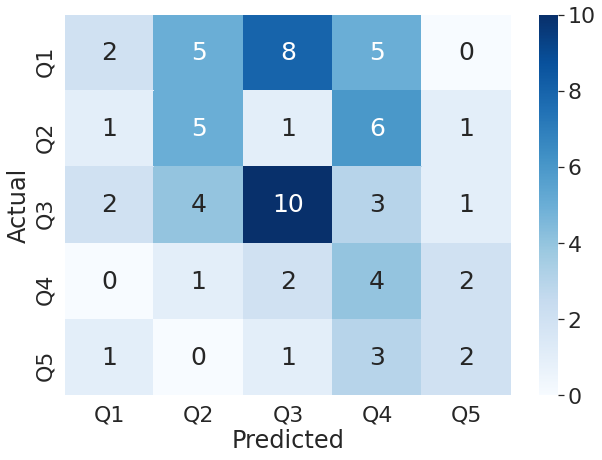

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NNI_RMSprops_std_indv.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## Training (no validation)

Training the network with the training dataset only (no validation split) in Optuna framework with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function to get data loader functions

def get_loaders_NNI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_NNI[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_NNI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_NNI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  train_label = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
    
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           #train_label.append(output.argmax(dim=1))
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       #train_label.append(train_lab)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_NNI_RMSprops_std.torch")
       
  
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_NNI, n_trials=1)


joblib.dump(study, "./optuna_NNI_drop.torch")

Epoch: 1 	Training Loss:  1.644 	Train_Accu: 22%  
Epoch: 2 	Training Loss:  1.599 	Train_Accu: 25%  
Epoch: 3 	Training Loss:  1.579 	Train_Accu: 29%  
Epoch: 4 	Training Loss:  1.549 	Train_Accu: 30%  
Epoch: 5 	Training Loss:  1.528 	Train_Accu: 34%  
Epoch: 6 	Training Loss:  1.483 	Train_Accu: 35%  
Epoch: 7 	Training Loss:  1.431 	Train_Accu: 45%  
Epoch: 8 	Training Loss:  1.413 	Train_Accu: 42%  
Epoch: 9 	Training Loss:  1.400 	Train_Accu: 44%  
Epoch: 10 	Training Loss:  1.302 	Train_Accu: 48%  
Epoch: 11 	Training Loss:  1.251 	Train_Accu: 50%  
Epoch: 12 	Training Loss:  1.235 	Train_Accu: 49%  
Epoch: 13 	Training Loss:  1.140 	Train_Accu: 55%  
Epoch: 14 	Training Loss:  1.091 	Train_Accu: 57%  
Epoch: 15 	Training Loss:  1.049 	Train_Accu: 61%  
Epoch: 16 	Training Loss:  1.027 	Train_Accu: 61%  
Epoch: 17 	Training Loss:  1.004 	Train_Accu: 59%  
Epoch: 18 	Training Loss:  0.950 	Train_Accu: 63%  
Epoch: 19 	Training Loss:  0.886 	Train_Accu: 69%  
Epoch: 20 	Training L

[W 2021-08-19 19:07:18,075] Trial 3 failed because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [395, 10000]')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-36-7faf1e2c5143>", line 100, in train_NNI
    cf_matrix = confusion_matrix(labels_actual, train_label)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 268, in confusion_matrix
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 80, in _check_targets
    check_consistent_length(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 212, in check_consistent_length
    " samples: %r" % [int(l) for l in lengths])
ValueError: Found input variables with inconsistent n

Epoch: 250 	Training Loss:  0.024 	Train_Accu: 99%  


ValueError: ignored

### Test

tensor([1, 3, 0, 2, 2, 1, 2, 2, 2, 1, 1, 3, 0, 3, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 4, 4, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 0, 0, 3, 2, 1, 2, 3, 3,
        3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 3, 2, 1, 0, 2, 2, 2, 1, 1])
labels tensor([0, 0, 0, 3, 2, 3, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
        3, 1, 1, 2, 3, 2, 2, 2, 3, 1, 0, 0, 4, 4, 4, 4, 2, 1, 3, 3, 2, 0, 1, 4,
        4, 4, 3, 3, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0])
correct : 22
test_Accuracy % : 31.4
kappa 0.3248917464899619
[[5 5 5 5 0]
 [4 6 1 3 0]
 [6 2 9 2 1]
 [1 2 4 1 1]
 [0 0 0 6 1]]


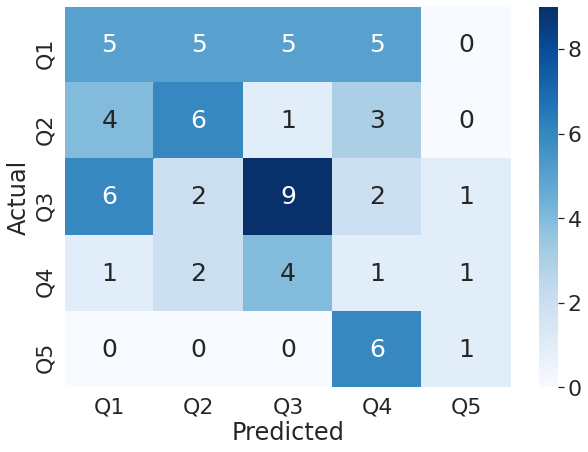

In [ ]:
# # Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_NNI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

## NSI_Rain

In [ ]:
# Reading rainfall file of NSI region 
Data_Rain_NSI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_NSI_regional_ave_time_series.csv")
Data_Rain_NSI

,time,Rain_bc,cat_3,cat_5,anomalies,region
0,1981-04-01,518.489941,3,4,85.363579,NSI
1,1981-05-01,638.632523,3,5,152.135448,NSI
2,1981-06-01,632.856496,3,4,82.627150,NSI
3,1981-07-01,728.721291,3,5,148.135826,NSI
4,1981-08-01,630.912992,2,4,33.379050,NSI
...,...,...,...,...,...,...
460,2019-08-01,450.869153,1,1,-146.664789,NSI
461,2019-09-01,582.496815,2,3,-10.172375,NSI
462,2019-10-01,521.115842,1,1,-113.011313,NSI
463,2019-11-01,595.341576,2,3,-29.604627,NSI


In [ ]:
# Extracting label column from NSI region dataframe
labels_Rain_NSI = Data_Rain_NSI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 


### Training
Training the network with the training and validation dataset in Optuna frame work with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of rainfall_NSI region into tensors
labelsTensors_NSI_rain = labels_Tensors(labels_Rain_NSI) # This represents y

In [ ]:
# Function to get data loader functions

def get_valid_loaders_NSI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NSI_rain[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_Rain_NSI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NSI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NSI_rain[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_NSI_rain[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_NSI_rain[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NSI_RMSprops_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-08-25 02:01:48,291] A new study created in memory with name: no-name-a40c4110-19c2-48ce-8306-5fc823cc9d27


In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_Rain_NSI, n_trials=1)


joblib.dump(study, "drive/MyDrive/DL_project/optimise_valid_NSI")

Epoch: 1 	Training Loss:  1.687 	Train_Accu: 18%  	Valid_Acc:24%  	Val_kappa : 0.123  
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 23%  	Valid_Acc:23%  	Val_kappa : -0.014  
Epoch: 3 	Training Loss:  1.594 	Train_Accu: 26%  	Valid_Acc:14%  	Val_kappa : -0.023  
Epoch: 4 	Training Loss:  1.596 	Train_Accu: 26%  	Valid_Acc:27%  	Val_kappa : 0.178  
Epoch: 5 	Training Loss:  1.552 	Train_Accu: 32%  	Valid_Acc:11%  	Val_kappa : 0.006  
Epoch: 6 	Training Loss:  1.542 	Train_Accu: 30%  	Valid_Acc:13%  	Val_kappa : -0.121  
Epoch: 7 	Training Loss:  1.518 	Train_Accu: 32%  	Valid_Acc:20%  	Val_kappa : -0.002  
Epoch: 8 	Training Loss:  1.483 	Train_Accu: 37%  	Valid_Acc:14%  	Val_kappa : 0.118  
Epoch: 9 	Training Loss:  1.455 	Train_Accu: 39%  	Valid_Acc:24%  	Val_kappa : 0.092  
Epoch: 10 	Training Loss:  1.386 	Train_Accu: 42%  	Valid_Acc:16%  	Val_kappa : 0.112  
Epoch: 11 	Training Loss:  1.356 	Train_Accu: 43%  	Valid_Acc:20%  	Val_kappa : 0.033  
Epoch: 12 	Training Loss:  1.272 	Tra

[I 2021-08-25 02:05:25,466] Trial 2 finished with value: 18.6 and parameters: {}. Best is trial 2 with value: 18.6.


['drive/MyDrive/DL_project/optimise_valid_NSI']

### Test

tensor([0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 4, 0, 4, 2, 4, 3, 0, 0, 0, 1, 3, 3, 1, 1, 0, 1, 0, 2, 2, 0, 3,
        2, 1, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 3, 2, 2, 2, 2, 1])
labels tensor([0, 2, 4, 4, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 3, 4, 2, 2, 1, 0, 0, 0, 1, 3,
        4, 1, 3, 4, 4, 1, 1, 0, 2, 2, 3, 2, 2, 2, 3, 1, 0, 0, 2, 1, 0, 0, 0, 4,
        4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 2, 0, 2, 4])
correct : 24
test_Accuracy % : 34.3
kappa 0.1950718685831624
[[19  1  6  1  1]
 [ 6  1  3  0  1]
 [ 6  2  2  4  0]
 [ 4  0  1  1  1]
 [ 4  2  1  2  1]]


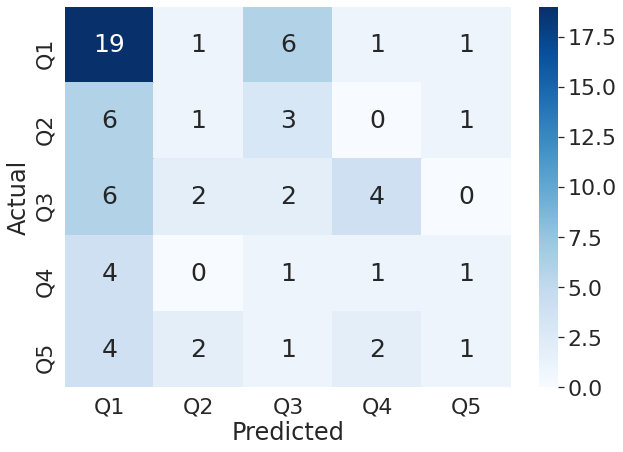

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NSI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NSI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

### Training (no validation)

In [ ]:
# Function to get data loader functions

def get_loaders_NSI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_NSI_rain[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_NSI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_NSI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_NSI_RMSprops.torch")
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_NSI, n_trials=1)


joblib.dump(study, "./optuna_NSI_drop.torch")

Epoch: 1 	Training Loss:  1.665 	Train_Accu: 21%  
Epoch: 2 	Training Loss:  1.606 	Train_Accu: 21%  
Epoch: 3 	Training Loss:  1.587 	Train_Accu: 22%  
Epoch: 4 	Training Loss:  1.588 	Train_Accu: 24%  
Epoch: 5 	Training Loss:  1.548 	Train_Accu: 31%  
Epoch: 6 	Training Loss:  1.551 	Train_Accu: 30%  
Epoch: 7 	Training Loss:  1.515 	Train_Accu: 34%  
Epoch: 8 	Training Loss:  1.487 	Train_Accu: 33%  
Epoch: 9 	Training Loss:  1.455 	Train_Accu: 40%  
Epoch: 10 	Training Loss:  1.407 	Train_Accu: 41%  
Epoch: 11 	Training Loss:  1.325 	Train_Accu: 43%  
Epoch: 12 	Training Loss:  1.305 	Train_Accu: 47%  
Epoch: 13 	Training Loss:  1.269 	Train_Accu: 48%  
Epoch: 14 	Training Loss:  1.219 	Train_Accu: 48%  
Epoch: 15 	Training Loss:  1.095 	Train_Accu: 56%  
Epoch: 16 	Training Loss:  1.116 	Train_Accu: 57%  
Epoch: 17 	Training Loss:  1.076 	Train_Accu: 57%  
Epoch: 18 	Training Loss:  0.976 	Train_Accu: 61%  
Epoch: 19 	Training Loss:  0.966 	Train_Accu: 63%  
Epoch: 20 	Training L

[I 2021-08-25 23:14:54,938] Trial 2 finished with value: 99.5 and parameters: {}. Best is trial 2 with value: 99.5.


Epoch: 250 	Training Loss:  0.015 	Train_Accu: 99%  


['./optuna_NSI_drop.torch']

### Test

tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 2,
        0, 0, 0, 4, 4, 4, 3, 4, 2, 0, 0, 2, 0, 3, 3, 3, 1, 1, 0, 3, 0, 0, 2, 3,
        3, 1, 1, 2, 4, 2, 2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 3, 2, 2, 4])
labels tensor([0, 2, 4, 4, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 3, 4, 2, 2, 1, 0, 0, 0, 1, 3,
        4, 1, 3, 4, 4, 1, 1, 0, 2, 2, 3, 2, 2, 2, 3, 1, 0, 0, 2, 1, 0, 0, 0, 4,
        4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 2, 0, 2, 4])
correct : 23
test_Accuracy % : 32.9
kappa 0.21990049751243768
[[15  6  4  2  1]
 [ 4  0  1  4  2]
 [ 6  2  3  3  0]
 [ 3  1  1  2  0]
 [ 3  2  0  2  3]]


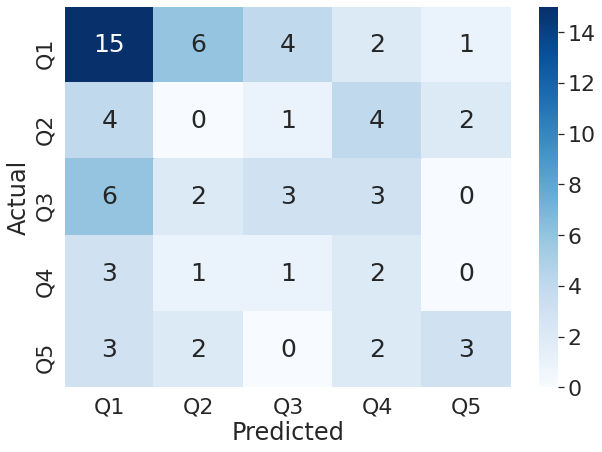

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NSI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_NSI_RMSprops.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## WSI_Rain

In [ ]:
# Reading rainfall file of NNI region 
Data_Rain_WSI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_WSI_regional_ave_time_series.csv")
Data_Rain_WSI

,time,Rain_bc,cat_3,cat_5,anomalies,region
0,1981-04-01,754.639738,3,5,149.581434,WSI
1,1981-05-01,715.682957,2,4,54.732620,WSI
2,1981-06-01,649.918240,2,3,-20.089857,WSI
3,1981-07-01,609.927346,2,2,-40.021983,WSI
4,1981-08-01,513.748260,1,1,-107.608177,WSI
...,...,...,...,...,...,...
460,2019-08-01,512.908271,1,1,-108.448166,WSI
461,2019-09-01,585.456530,2,2,-44.543182,WSI
462,2019-10-01,628.058786,1,2,-78.309772,WSI
463,2019-11-01,809.331997,3,4,87.511779,WSI


In [ ]:
# Extracting label column
labels_Rain_WSI = Data_Rain_WSI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of rainfall_WSI region into tensors
labelsTensors_WSI_rain = labels_Tensors(labels_Rain_WSI) # This represents y

### Training
Training the network with the training and validation dataset in Optuna frame work with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function to get data loader functions

def get_valid_loaders_WSI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_WSI_rain[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_WSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
  

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_Rain_WSI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_WSI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_WSI_rain[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_WSI_rain[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_WSI_rain[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_WSI_rain[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_WSI_RMSprops_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_Rain_WSI, n_trials=1)


joblib.dump(study, "optimise_valid_WSI_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.705 	Train_Accu: 21%  	Valid_Acc:23%  	Val_kappa : -0.238  
Epoch: 2 	Training Loss:  1.613 	Train_Accu: 26%  	Valid_Acc:16%  	Val_kappa : -0.176  
Epoch: 3 	Training Loss:  1.600 	Train_Accu: 21%  	Valid_Acc:29%  	Val_kappa : 0.143  
Epoch: 4 	Training Loss:  1.579 	Train_Accu: 27%  	Valid_Acc:30%  	Val_kappa : 0.090  
Epoch: 5 	Training Loss:  1.580 	Train_Accu: 28%  	Valid_Acc:24%  	Val_kappa : 0.041  
Epoch: 6 	Training Loss:  1.558 	Train_Accu: 27%  	Valid_Acc:20%  	Val_kappa : 0.147  
Epoch: 7 	Training Loss:  1.522 	Train_Accu: 34%  	Valid_Acc:23%  	Val_kappa : 0.129  
Epoch: 8 	Training Loss:  1.523 	Train_Accu: 31%  	Valid_Acc:24%  	Val_kappa : 0.233  
Epoch: 9 	Training Loss:  1.489 	Train_Accu: 34%  	Valid_Acc:21%  	Val_kappa : 0.019  
Epoch: 10 	Training Loss:  1.443 	Train_Accu: 41%  	Valid_Acc:19%  	Val_kappa : -0.053  
Epoch: 11 	Training Loss:  1.404 	Train_Accu: 39%  	Valid_Acc:27%  	Val_kappa : 0.146  
Epoch: 12 	Training Loss:  1.396 	Trai

[I 2021-08-25 23:27:22,359] Trial 4 finished with value: 22.9 and parameters: {}. Best is trial 2 with value: 99.5.


Epoch: 250 	Training Loss:  0.024 	Train_Accu: 99%  	Valid_Acc:23%  	Val_kappa : 0.104  


['optimise_valid_WSI_drop(0.5).torch']

### Test

tensor([0, 0, 3, 4, 4, 1, 0, 0, 0, 0, 4, 0, 0, 2, 0, 3, 1, 1, 1, 1, 2, 4, 4, 0,
        4, 4, 2, 3, 3, 4, 4, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2])
labels tensor([0, 0, 3, 4, 4, 1, 0, 1, 3, 3, 2, 0, 0, 3, 3, 4, 4, 4, 1, 1, 1, 1, 2, 3,
        4, 4, 4, 4, 4, 2, 1, 0, 2, 3, 4, 4, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2,
        3, 4, 3, 1, 1, 0, 1, 0, 1, 0, 2, 1, 4, 4, 4, 2, 3, 0, 1, 1, 3, 4])
correct : 17
test_Accuracy % : 24.3
kappa 0.20479416362688896
[[ 6  0 11  1  0]
 [ 1  4  7  1  2]
 [ 3  0  2  0  3]
 [ 4  1  6  1  0]
 [ 1  2  7  3  4]]


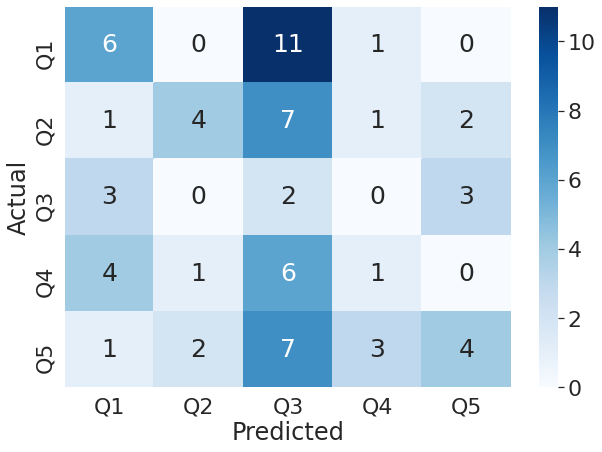

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_WSI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_WSI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

### Training (no validation)

In [ ]:
# Function to get data loader functions

def get_loaders_WSI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_WSI_rain[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_WSI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_WSI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_WSI_RMSprops_std_indv.torch")
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_WSI, n_trials=1)


joblib.dump(study, "./optuna_WSI_drop.torch")

Epoch: 1 	Training Loss:  1.637 	Train_Accu: 19%  
Epoch: 2 	Training Loss:  1.603 	Train_Accu: 25%  
Epoch: 3 	Training Loss:  1.598 	Train_Accu: 24%  
Epoch: 4 	Training Loss:  1.570 	Train_Accu: 27%  
Epoch: 5 	Training Loss:  1.573 	Train_Accu: 25%  
Epoch: 6 	Training Loss:  1.538 	Train_Accu: 29%  
Epoch: 7 	Training Loss:  1.505 	Train_Accu: 33%  
Epoch: 8 	Training Loss:  1.478 	Train_Accu: 34%  
Epoch: 9 	Training Loss:  1.489 	Train_Accu: 34%  
Epoch: 10 	Training Loss:  1.424 	Train_Accu: 46%  
Epoch: 11 	Training Loss:  1.353 	Train_Accu: 43%  
Epoch: 12 	Training Loss:  1.332 	Train_Accu: 44%  
Epoch: 13 	Training Loss:  1.276 	Train_Accu: 47%  
Epoch: 14 	Training Loss:  1.245 	Train_Accu: 51%  
Epoch: 15 	Training Loss:  1.207 	Train_Accu: 55%  
Epoch: 16 	Training Loss:  1.149 	Train_Accu: 53%  
Epoch: 17 	Training Loss:  1.170 	Train_Accu: 51%  
Epoch: 18 	Training Loss:  1.028 	Train_Accu: 59%  
Epoch: 19 	Training Loss:  1.037 	Train_Accu: 57%  
Epoch: 20 	Training L

[I 2021-08-25 23:53:33,371] Trial 5 finished with value: 98.0 and parameters: {}. Best is trial 2 with value: 99.5.


['./optuna_WSI_drop.torch']

### Test

tensor([2, 2, 3, 0, 4, 2, 0, 0, 3, 0, 0, 4, 0, 2, 3, 3, 2, 4, 1, 2, 2, 4, 4, 3,
        4, 4, 2, 0, 3, 4, 4, 2, 3, 2, 2, 2, 1, 4, 2, 2, 2, 2, 3, 3, 0, 2, 0, 0,
        3, 0, 2, 2, 4, 0, 0, 3, 0, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 2])
labels tensor([0, 2, 4, 4, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 3, 4, 2, 2, 1, 0, 0, 0, 1, 3,
        4, 1, 3, 4, 4, 1, 1, 0, 2, 2, 3, 2, 2, 2, 3, 1, 0, 0, 2, 1, 0, 0, 0, 4,
        4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 2, 0, 2, 4])
correct : 20
test_Accuracy % : 28.6
kappa 0.06406685236768783
[[9 1 7 9 2]
 [1 1 3 1 5]
 [0 1 6 4 3]
 [0 0 4 3 0]
 [4 0 1 4 1]]


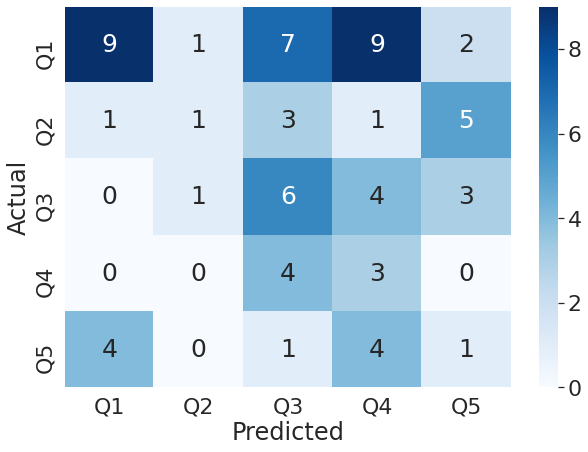

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NSI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_WSI_RMSprops_std_indv.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## ESI_rain

In [ ]:
# Reading rainfall file of ESI region 
Data_Rain_ESI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_ESI_regional_ave_time_series.csv")
Data_Rain_ESI

,time,Rain_bc,cat_3,cat_5,anomalies,region
0,1981-04-01,154.501766,2,3,-8.231351,ESI
1,1981-05-01,156.471221,2,3,-9.666739,ESI
2,1981-06-01,168.750909,2,4,5.076587,ESI
3,1981-07-01,200.079117,3,4,27.608178,ESI
4,1981-08-01,225.323325,3,5,54.264734,ESI
...,...,...,...,...,...,...
460,2019-08-01,144.404312,1,2,-26.654279,ESI
461,2019-09-01,165.436987,2,3,-1.495053,ESI
462,2019-10-01,160.811636,2,3,-9.769120,ESI
463,2019-11-01,174.390909,2,4,4.433875,ESI


In [ ]:
# Extracting quantiles from the ESI dataset
labels_Rain_ESI = Data_Rain_ESI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of rainfall_ESI region into tensors
labelsTensors_ESI_rain = labels_Tensors(labels_Rain_ESI) # This represents y

In [ ]:
# Training data lables distribution
Train_labels = labels_Rain_ESI[:324]
Train_labels.value_counts()

3    70
4    66
2    64
5    62
1    62
Name: cat_5, dtype: int64

### Training 

Training the network with the training and validation dataset in Optuna frame work with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function to get data loader functions

def get_valid_loaders_ESI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_ESI_rain[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_ESI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
  

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_Rain_ESI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_ESI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_ESI_rain[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_ESI_rain[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_ESI_rain[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_ESI_rain[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_ESI_RMSprops_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-04-06 22:28:22,461] A new study created in memory with name: no-name-f209b415-e09f-4d3b-b524-a956d7c97d11


In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_Rain_ESI, n_trials=1)

joblib.dump(study, "drive/MyDrive/DL_project/optimise_valid_ESI.torch")

Epoch: 1 	Training Loss:  1.695 	Train_Accu: 21%  	Valid_Acc:20%  	Val_kappa : -0.032  
Epoch: 2 	Training Loss:  1.615 	Train_Accu: 22%  	Valid_Acc:23%  	Val_kappa : 0.145  
Epoch: 3 	Training Loss:  1.595 	Train_Accu: 23%  	Valid_Acc:16%  	Val_kappa : 0.042  
Epoch: 4 	Training Loss:  1.591 	Train_Accu: 26%  	Valid_Acc:21%  	Val_kappa : 0.053  
Epoch: 5 	Training Loss:  1.559 	Train_Accu: 30%  	Valid_Acc:20%  	Val_kappa : -0.092  
Epoch: 6 	Training Loss:  1.564 	Train_Accu: 28%  	Valid_Acc:23%  	Val_kappa : 0.064  
Epoch: 7 	Training Loss:  1.542 	Train_Accu: 29%  	Valid_Acc:14%  	Val_kappa : -0.073  
Epoch: 8 	Training Loss:  1.517 	Train_Accu: 36%  	Valid_Acc:16%  	Val_kappa : -0.157  
Epoch: 9 	Training Loss:  1.474 	Train_Accu: 39%  	Valid_Acc:24%  	Val_kappa : 0.164  
Epoch: 10 	Training Loss:  1.447 	Train_Accu: 38%  	Valid_Acc:21%  	Val_kappa : -0.025  
Epoch: 11 	Training Loss:  1.395 	Train_Accu: 43%  	Valid_Acc:16%  	Val_kappa : -0.007  
Epoch: 12 	Training Loss:  1.373 	T

[I 2021-08-26 00:02:24,074] Trial 6 finished with value: 20.0 and parameters: {}. Best is trial 2 with value: 99.5.


Epoch: 250 	Training Loss:  0.018 	Train_Accu: 99%  	Valid_Acc:20%  	Val_kappa : -0.113  


['drive/MyDrive/DL_project/optimise_valid_ESI.torch']

### Test

tensor([1, 2, 1, 1, 1, 1, 3, 3, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1,
        0, 1, 0, 0, 4, 1, 1, 1, 0, 3, 3, 1, 0, 3, 3, 3, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 2, 2, 4, 2, 4, 1, 2, 4, 4, 3, 1, 3, 3, 3, 4, 1, 4, 3, 3, 0])
labels tensor([1, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 1, 2, 0, 0, 0, 0, 2, 1,
        2, 0, 2, 1, 2, 0, 1, 2, 4, 3, 3, 1, 3, 4, 4, 4, 4, 3, 4, 3, 0, 0, 1, 4,
        4, 4, 4, 4, 0, 0, 0, 1, 4, 4, 4, 1, 1, 1, 3, 2, 2, 1, 2, 2, 3, 3])
correct : 18
test_Accuracy % : 25.7
kappa 0.036308623298033305
[[3 7 3 4 2]
 [2 9 0 2 0]
 [2 5 0 2 3]
 [2 3 0 4 0]
 [4 4 4 3 2]]


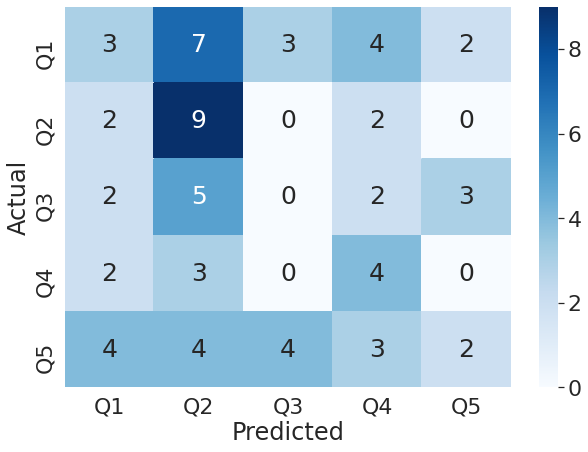

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_ESI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load( "drive/MyDrive/DL_project/check_valid_ESI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

### Training (no validation)

In [ ]:
# Function to get data loader functions

def get_loaders_ESI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_ESI_rain[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_ESI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_ESI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_ESI_RMSprops_indv.torch")
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_ESI, n_trials=1)


joblib.dump(study, "./optuna_ESI_drop.torch")

Epoch: 1 	Training Loss:  1.674 	Train_Accu: 21%  
Epoch: 2 	Training Loss:  1.618 	Train_Accu: 23%  
Epoch: 3 	Training Loss:  1.613 	Train_Accu: 18%  
Epoch: 4 	Training Loss:  1.596 	Train_Accu: 23%  
Epoch: 5 	Training Loss:  1.584 	Train_Accu: 26%  
Epoch: 6 	Training Loss:  1.581 	Train_Accu: 24%  
Epoch: 7 	Training Loss:  1.563 	Train_Accu: 27%  
Epoch: 8 	Training Loss:  1.536 	Train_Accu: 32%  
Epoch: 9 	Training Loss:  1.504 	Train_Accu: 35%  
Epoch: 10 	Training Loss:  1.481 	Train_Accu: 36%  
Epoch: 11 	Training Loss:  1.378 	Train_Accu: 46%  
Epoch: 12 	Training Loss:  1.393 	Train_Accu: 42%  
Epoch: 13 	Training Loss:  1.333 	Train_Accu: 42%  
Epoch: 14 	Training Loss:  1.270 	Train_Accu: 50%  
Epoch: 15 	Training Loss:  1.248 	Train_Accu: 47%  
Epoch: 16 	Training Loss:  1.196 	Train_Accu: 52%  
Epoch: 17 	Training Loss:  1.144 	Train_Accu: 55%  
Epoch: 18 	Training Loss:  1.077 	Train_Accu: 55%  
Epoch: 19 	Training Loss:  1.006 	Train_Accu: 59%  
Epoch: 20 	Training L

[I 2021-08-26 00:17:22,968] Trial 7 finished with value: 99.2 and parameters: {}. Best is trial 2 with value: 99.5.


Epoch: 250 	Training Loss:  0.023 	Train_Accu: 99%  


['./optuna_ESI_drop.torch']

### Test

tensor([1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1,
        0, 0, 0, 0, 2, 4, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 0, 0, 0, 0, 2, 2, 0, 0,
        0, 2, 2, 2, 2, 0, 4, 4, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 4, 3, 3, 1])
labels tensor([1, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 1, 2, 0, 0, 0, 0, 2, 1,
        2, 0, 2, 1, 2, 0, 1, 2, 4, 3, 3, 1, 3, 4, 4, 4, 4, 3, 4, 3, 0, 0, 1, 4,
        4, 4, 4, 4, 0, 0, 0, 1, 4, 4, 4, 1, 1, 1, 3, 2, 2, 1, 2, 2, 3, 3])
correct : 17
test_Accuracy % : 24.3
kappa 0.003350083752093891
[[8 4 5 0 2]
 [3 6 3 0 1]
 [4 4 2 1 1]
 [4 2 2 1 0]
 [6 2 8 1 0]]


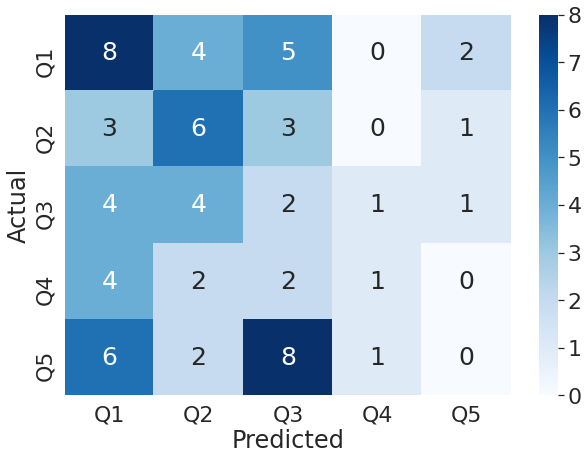

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_ESI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_ESI_RMSprops_indv.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## WNI_rain

In [ ]:
# Reading rainfall file of ESI region 
Data_Rain_WNI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_WNI_regional_ave_time_series.csv")
Data_Rain_WNI

,time,Rain_bc,cat_3,cat_5,anomalies,region
0,1981-04-01,294.134750,2,3,-24.330236,WNI
1,1981-05-01,332.026667,2,3,-23.756928,WNI
2,1981-06-01,461.024500,3,5,46.977206,WNI
3,1981-07-01,550.865250,3,5,90.264794,WNI
4,1981-08-01,575.374250,3,5,102.447406,WNI
...,...,...,...,...,...,...
460,2019-08-01,442.008667,2,2,-30.918178,WNI
461,2019-09-01,476.844000,2,3,15.506572,WNI
462,2019-10-01,403.274333,1,2,-60.727456,WNI
463,2019-11-01,357.037750,1,1,-87.472006,WNI


In [ ]:
# Extracting quantiles from the ESI dataset
labels_Rain_WNI = Data_Rain_WNI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of rainfall_WNI region into tensors
labelsTensors_WNI_rain = labels_Tensors(labels_Rain_WNI) # This represents y

In [ ]:
# Training data lables distribution
Train_labels = labels_Rain_WNI[:324]
Train_labels.value_counts()

1    67
5    65
4    65
2    65
3    62
Name: cat_5, dtype: int64

### Training 

Training the network with the training and validation dataset in Optuna frame work with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function to get data loader functions

def get_valid_loaders_WNI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_WNI_rain[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_WNI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
  

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_Rain_WNI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_WNI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_WNI_rain[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_WNI_rain[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_WNI_rain[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_WNI_rain[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_WNI_RMSprops_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-06-15 01:01:28,935] A new study created in memory with name: no-name-6791f3d4-abd7-433a-a951-1b1c4674c130


In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_Rain_WNI, n_trials=1)


joblib.dump(study, "drive/MyDrive/DL_project/optimise_valid_ESI.torch")

Epoch: 1 	Training Loss:  1.704 	Train_Accu: 18%  	Valid_Acc:21%  	Val_kappa : 0.030  
Epoch: 2 	Training Loss:  1.611 	Train_Accu: 23%  	Valid_Acc:14%  	Val_kappa : -0.040  
Epoch: 3 	Training Loss:  1.597 	Train_Accu: 25%  	Valid_Acc:20%  	Val_kappa : 0.045  
Epoch: 4 	Training Loss:  1.587 	Train_Accu: 25%  	Valid_Acc:21%  	Val_kappa : 0.022  
Epoch: 5 	Training Loss:  1.563 	Train_Accu: 29%  	Valid_Acc:20%  	Val_kappa : 0.031  
Epoch: 6 	Training Loss:  1.552 	Train_Accu: 33%  	Valid_Acc:23%  	Val_kappa : -0.019  
Epoch: 7 	Training Loss:  1.558 	Train_Accu: 31%  	Valid_Acc:17%  	Val_kappa : 0.059  
Epoch: 8 	Training Loss:  1.522 	Train_Accu: 33%  	Valid_Acc:29%  	Val_kappa : 0.207  
Epoch: 9 	Training Loss:  1.492 	Train_Accu: 40%  	Valid_Acc:21%  	Val_kappa : -0.120  
Epoch: 10 	Training Loss:  1.471 	Train_Accu: 36%  	Valid_Acc:21%  	Val_kappa : 0.051  
Epoch: 11 	Training Loss:  1.405 	Train_Accu: 42%  	Valid_Acc:23%  	Val_kappa : 0.175  
Epoch: 12 	Training Loss:  1.384 	Trai

[I 2021-08-26 00:54:08,740] Trial 8 finished with value: 25.7 and parameters: {}. Best is trial 2 with value: 99.5.


Epoch: 250 	Training Loss:  0.048 	Train_Accu: 98%  	Valid_Acc:26%  	Val_kappa : 0.166  


['drive/MyDrive/DL_project/optimise_valid_ESI.torch']

### Test

tensor([0, 0, 4, 2, 2, 2, 3, 3, 2, 4, 2, 4, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 0, 0,
        0, 0, 0, 4, 4, 4, 4, 1, 1, 1, 3, 2, 2, 1, 3, 1, 1, 2, 2, 0, 1, 0, 3, 3,
        4, 2, 2, 2, 3, 2, 3, 3, 1, 0, 0, 2, 1, 3, 4, 0, 1, 3, 2, 2, 4, 4])
labels tensor([0, 1, 3, 4, 0, 1, 1, 1, 2, 1, 0, 0, 0, 4, 4, 4, 4, 4, 2, 1, 0, 0, 0, 0,
        2, 0, 3, 4, 4, 2, 3, 1, 4, 2, 3, 2, 3, 4, 4, 4, 1, 2, 4, 4, 1, 0, 0, 2,
        4, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1])
correct : 21
test_Accuracy % : 30.0
kappa 0.2044658055472114
[[7 2 6 2 2]
 [2 4 3 5 2]
 [1 1 5 2 2]
 [1 0 1 2 2]
 [1 3 9 2 3]]


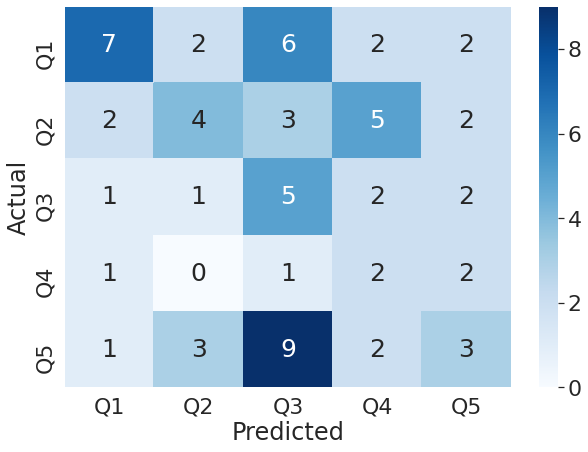

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_WNI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_WNI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

### Training (no validation)

In [ ]:
# Function to get data loader functions

def get_loaders_WNI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_WNI_rain[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_WNI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_WNI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_WNI_RMSprops_indv_std.torch")
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_WNI, n_trials=1)


joblib.dump(study, "./optuna_WNI_drop.torch")

Epoch: 1 	Training Loss:  1.645 	Train_Accu: 18%  
Epoch: 2 	Training Loss:  1.611 	Train_Accu: 21%  
Epoch: 3 	Training Loss:  1.596 	Train_Accu: 23%  
Epoch: 4 	Training Loss:  1.597 	Train_Accu: 23%  
Epoch: 5 	Training Loss:  1.571 	Train_Accu: 28%  
Epoch: 6 	Training Loss:  1.547 	Train_Accu: 30%  
Epoch: 7 	Training Loss:  1.541 	Train_Accu: 33%  
Epoch: 8 	Training Loss:  1.506 	Train_Accu: 35%  
Epoch: 9 	Training Loss:  1.479 	Train_Accu: 36%  
Epoch: 10 	Training Loss:  1.420 	Train_Accu: 39%  
Epoch: 11 	Training Loss:  1.402 	Train_Accu: 43%  
Epoch: 12 	Training Loss:  1.355 	Train_Accu: 48%  
Epoch: 13 	Training Loss:  1.333 	Train_Accu: 43%  
Epoch: 14 	Training Loss:  1.235 	Train_Accu: 51%  
Epoch: 15 	Training Loss:  1.271 	Train_Accu: 48%  
Epoch: 16 	Training Loss:  1.181 	Train_Accu: 52%  
Epoch: 17 	Training Loss:  1.182 	Train_Accu: 53%  
Epoch: 18 	Training Loss:  1.072 	Train_Accu: 59%  
Epoch: 19 	Training Loss:  1.003 	Train_Accu: 64%  
Epoch: 20 	Training L

[I 2021-08-26 01:04:49,451] Trial 9 finished with value: 99.7 and parameters: {}. Best is trial 9 with value: 99.7.


Epoch: 250 	Training Loss:  0.016 	Train_Accu: 100%  


['./optuna_WNI_drop.torch']

### Test

tensor([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 4, 4, 4, 1, 1, 1, 0, 1, 2, 4, 1, 1, 1, 1, 4, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 4, 3, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 3, 2, 4, 2])
labels tensor([0, 1, 3, 4, 0, 1, 1, 1, 2, 1, 0, 0, 0, 4, 4, 4, 4, 4, 2, 1, 0, 0, 0, 0,
        2, 0, 3, 4, 4, 2, 3, 1, 4, 2, 3, 2, 3, 4, 4, 4, 1, 2, 4, 4, 1, 0, 0, 2,
        4, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1])
correct : 18
test_Accuracy % : 25.7
kappa 0.13368312991901454
[[3 6 8 1 1]
 [0 8 7 0 1]
 [1 3 4 2 1]
 [2 0 3 0 1]
 [2 5 6 2 3]]


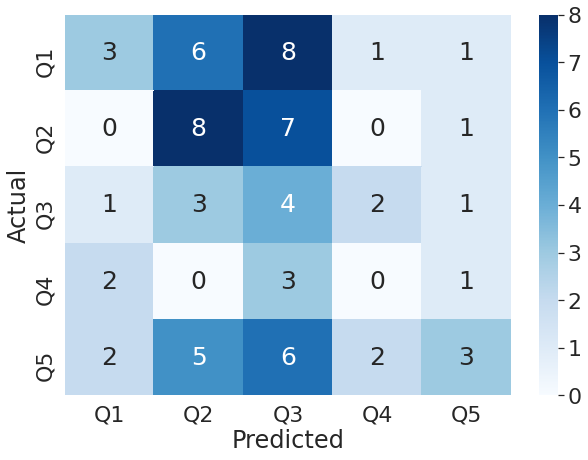

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_WNI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load( "drive/MyDrive/DL_project/check_WNI_RMSprops_indv_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## ENI_rain

In [ ]:
# Reading rainfall file of ESI region 
Data_Rain_ENI = pd.read_csv("drive/My Drive/DL_project/Target_Rain_ENI_regional_ave_time_series.csv")
Data_Rain_ENI

,time,Rain_bc,cat_3,cat_5,anomalies,region
0,1981-04-01,271.002261,2,2,-35.277979,ENI
1,1981-05-01,372.490293,3,4,38.612542,ENI
2,1981-06-01,519.262965,3,5,149.049311,ENI
3,1981-07-01,576.990359,3,5,150.647631,ENI
4,1981-08-01,629.490758,3,5,198.167742,ENI
...,...,...,...,...,...,...
460,2019-08-01,321.622739,1,1,-109.700277,ENI
461,2019-09-01,316.468218,1,2,-85.917467,ENI
462,2019-10-01,321.417686,2,2,-37.320809,ENI
463,2019-11-01,283.191689,1,2,-48.170731,ENI


In [ ]:
# Extracting quantiles from the ESI dataset
labels_Rain_ENI = Data_Rain_ENI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of rainfall_ENI region into tensors
labelsTensors_ENI_rain = labels_Tensors(labels_Rain_ENI) # This represents y

In [ ]:
# Training data lables distribution
Train_labels = labels_Rain_ENI[:324]
Train_labels.value_counts()

3    69
1    67
2    66
5    61
4    61
Name: cat_5, dtype: int64

### Training 

Training the network with the training and validation dataset in Optuna frame work with RMSprop optimizer, batch size 10 and learning rate 0.0001.

In [ ]:
# Function to get data loader functions

def get_valid_loaders_ENI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_ENI_rain[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_ENI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
  

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_Rain_ENI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           #'dropout'       : 0.7,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_ENI(cfg['Batch_size'])
  model = Network_drop().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_ENI_rain[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_ENI_rain[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_ENI_rain[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_ENI_rain[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_ENI_RMSprops_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_Rain_ENI, n_trials=1)


joblib.dump(study, "drive/MyDrive/DL_project/optimise_valid_ENI")

Epoch: 1 	Training Loss:  1.732 	Train_Accu: 18%  	Valid_Acc:20%  	Val_kappa : 0.185  
Epoch: 2 	Training Loss:  1.604 	Train_Accu: 25%  	Valid_Acc:21%  	Val_kappa : 0.035  
Epoch: 3 	Training Loss:  1.599 	Train_Accu: 24%  	Valid_Acc:14%  	Val_kappa : -0.055  
Epoch: 4 	Training Loss:  1.580 	Train_Accu: 29%  	Valid_Acc:10%  	Val_kappa : -0.267  
Epoch: 5 	Training Loss:  1.561 	Train_Accu: 28%  	Valid_Acc:21%  	Val_kappa : -0.011  
Epoch: 6 	Training Loss:  1.540 	Train_Accu: 33%  	Valid_Acc:19%  	Val_kappa : -0.058  
Epoch: 7 	Training Loss:  1.507 	Train_Accu: 34%  	Valid_Acc:13%  	Val_kappa : 0.131  
Epoch: 8 	Training Loss:  1.477 	Train_Accu: 35%  	Valid_Acc:13%  	Val_kappa : -0.002  
Epoch: 9 	Training Loss:  1.428 	Train_Accu: 38%  	Valid_Acc:14%  	Val_kappa : -0.190  
Epoch: 10 	Training Loss:  1.443 	Train_Accu: 38%  	Valid_Acc:19%  	Val_kappa : 0.045  
Epoch: 11 	Training Loss:  1.365 	Train_Accu: 41%  	Valid_Acc:17%  	Val_kappa : -0.063  
Epoch: 12 	Training Loss:  1.357 	

[I 2021-08-26 01:16:07,964] Trial 10 finished with value: 12.9 and parameters: {}. Best is trial 9 with value: 99.7.


Epoch: 250 	Training Loss:  0.050 	Train_Accu: 98%  	Valid_Acc:13%  	Val_kappa : -0.190  


['drive/MyDrive/DL_project/optimise_valid_ENI']

### Test

tensor([1, 0, 3, 1, 1, 1, 3, 3, 3, 2, 4, 1, 2, 1, 3, 3, 1, 2, 2, 0, 1, 1, 1, 1,
        0, 2, 0, 1, 1, 4, 1, 4, 1, 4, 2, 2, 2, 2, 4, 4, 1, 4, 2, 1, 0, 3, 4, 3,
        4, 2, 2, 1, 1, 1, 4, 1, 3, 4, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2])
labels tensor([0, 3, 3, 3, 0, 1, 1, 3, 2, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 3, 3, 0, 1, 0,
        1, 0, 0, 1, 1, 2, 3, 3, 4, 1, 0, 1, 3, 4, 4, 4, 1, 1, 2, 1, 0, 0, 0, 2,
        4, 3, 3, 3, 1, 2, 1, 2, 3, 4, 4, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2])
correct : 25
test_Accuracy % : 35.7
kappa 0.2568292973875701
[[ 3  9  6  1  2]
 [ 1 11  2  1  3]
 [ 0  2  4  4  1]
 [ 2  4  3  3  1]
 [ 0  2  1  0  4]]


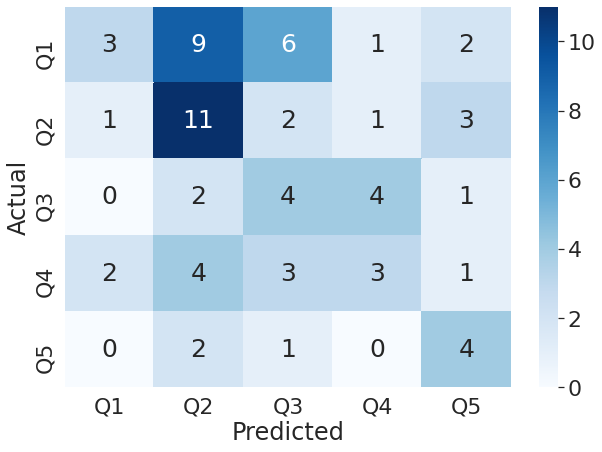

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_ENI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_ENI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

### Training (no validation)

In [ ]:
# Function to get data loader functions

def get_loaders_ENI(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:395], labelsTensors_ENI_rain[:395])
    #validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NSI_rain[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    #valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader

In [ ]:
# Main function to run

def train_ENI(trial):
  
  cfg = { 
          'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  0.0001,          
          'optimizer':  optim.RMSprop,
          'dropout'       : 0.5,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader = get_loaders_ENI(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  #valid_accuracy =[]
  train_losses =[]
  #valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
      #  valid_loss = 0
      #  valid_correct = 0
       train_acc = 0
       #valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

      #  with torch.no_grad(): 
      #     for batch_i, (data, target) in enumerate(valid_loader): 
      #         data, target = data.to(device), target.to(device)         
      #         output = model(data)
      #         output_c = output.cpu()
      #         target_c = target.cpu()
      #         loss = criterion(output_c, target_c) 
      #         valid_loss += loss.item()
      #         valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
      #         valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
      #  valid_loss = valid_loss/len(valid_loader)
      #  valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       #valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       #valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  '.format(epoch, train_loss, train_acc))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              #'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              #'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_ENI_RMSprops_std.torch")
      
   
  return  round(train_acc, 1)

In [ ]:
import joblib

study.optimize(train_ENI, n_trials=1)


joblib.dump(study, "./optuna_ENI_drop.torch")

Epoch: 1 	Training Loss:  1.656 	Train_Accu: 23%  
Epoch: 2 	Training Loss:  1.615 	Train_Accu: 24%  
Epoch: 3 	Training Loss:  1.591 	Train_Accu: 28%  
Epoch: 4 	Training Loss:  1.582 	Train_Accu: 27%  
Epoch: 5 	Training Loss:  1.555 	Train_Accu: 31%  
Epoch: 6 	Training Loss:  1.514 	Train_Accu: 34%  
Epoch: 7 	Training Loss:  1.479 	Train_Accu: 35%  
Epoch: 8 	Training Loss:  1.460 	Train_Accu: 39%  
Epoch: 9 	Training Loss:  1.435 	Train_Accu: 39%  
Epoch: 10 	Training Loss:  1.367 	Train_Accu: 44%  
Epoch: 11 	Training Loss:  1.318 	Train_Accu: 45%  
Epoch: 12 	Training Loss:  1.252 	Train_Accu: 50%  
Epoch: 13 	Training Loss:  1.222 	Train_Accu: 51%  
Epoch: 14 	Training Loss:  1.133 	Train_Accu: 56%  
Epoch: 15 	Training Loss:  1.116 	Train_Accu: 56%  
Epoch: 16 	Training Loss:  1.068 	Train_Accu: 59%  
Epoch: 17 	Training Loss:  1.050 	Train_Accu: 60%  
Epoch: 18 	Training Loss:  0.924 	Train_Accu: 64%  
Epoch: 19 	Training Loss:  0.859 	Train_Accu: 70%  
Epoch: 20 	Training L

[I 2021-08-26 01:29:37,987] Trial 12 finished with value: 99.5 and parameters: {}. Best is trial 9 with value: 99.7.


Epoch: 250 	Training Loss:  0.023 	Train_Accu: 99%  


['./optuna_ENI_drop.torch']

### Test

tensor([3, 4, 3, 3, 1, 1, 2, 1, 4, 3, 2, 3, 4, 1, 2, 3, 1, 2, 1, 3, 1, 1, 3, 0,
        0, 0, 0, 0, 4, 2, 4, 4, 1, 4, 3, 1, 1, 2, 1, 4, 1, 1, 4, 1, 4, 4, 0, 3,
        3, 3, 4, 4, 1, 3, 1, 1, 4, 4, 3, 4, 2, 0, 4, 1, 0, 4, 1, 1, 1, 1])
labels tensor([0, 3, 3, 3, 0, 1, 1, 3, 2, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 3, 3, 0, 1, 0,
        1, 0, 0, 1, 1, 2, 3, 3, 4, 1, 0, 1, 3, 4, 4, 4, 1, 1, 2, 1, 0, 0, 0, 2,
        4, 3, 3, 3, 1, 2, 1, 2, 3, 4, 4, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2])
correct : 25
test_Accuracy % : 35.7
kappa 0.2730272736096284
[[ 6  4  2  4  5]
 [ 2 11  2  1  2]
 [ 0  3  2  3  3]
 [ 0  3  0  4  6]
 [ 0  2  1  2  2]]


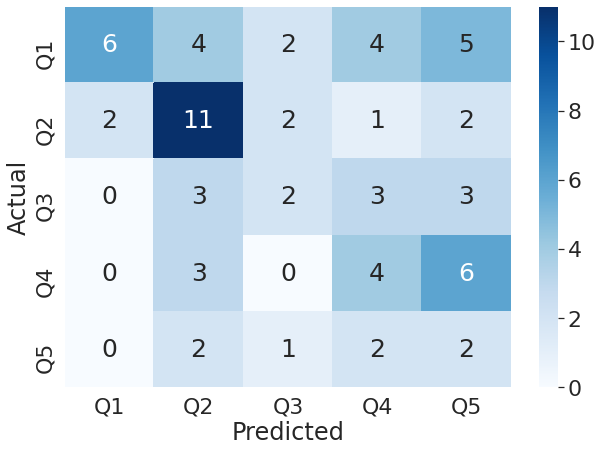

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_ENI_rain[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop()

checkpoint = torch.load("drive/MyDrive/DL_project/check_ENI_RMSprops_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

# Temperature data

## NNI_temp hyperparameter tuning

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_NNI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_NNI_regional_ave_time_series.csv")
Data_temp_NNI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,17.561887,3,5,0.964548,NNI
1,1981-05-01,15.096590,3,5,0.653660,NNI
2,1981-06-01,12.515731,3,4,0.390654,NNI
3,1981-07-01,10.417690,2,3,0.035998,NNI
4,1981-08-01,9.586142,2,3,-0.037651,NNI
...,...,...,...,...,...,...
460,2019-08-01,10.106427,3,5,0.482634,NNI
461,2019-09-01,10.697352,3,5,0.590812,NNI
462,2019-10-01,11.546830,3,4,0.230155,NNI
463,2019-11-01,13.554716,3,5,0.620366,NNI


In [ ]:
# Extracting lable column
labels_temp_NNI = Data_temp_NNI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_NNI region into tensors
labelsTensors_temp_NNI = labels_Tensors(labels_temp_NNI) # This represents y

In [ ]:
labelsTensors_temp_NNI.unique()

tensor([0, 1, 2, 3, 4])

In [ ]:
# Train lables distribution
Train_labels = labels_temp_NNI[:325]
Train_labels.value_counts()

5    69
2    69
1    69
3    62
4    55
Name: cat_5, dtype: int64

In [ ]:
# Function to get data loader functions

def get_valid_loaders_NNI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_NNI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_NNI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )


    return train_loader, valid_loader

NNI temperature experiments with different batch sizes, lr, optimisers, dropout rates.

In [ ]:
# Main function to run

def train_NNI(trial):
  
  cfg = { 
         'Batch_size' : trial.suggest_int('Batch_size', 1, 10),
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       : trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001]),          
          'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam, optim.RMSprop]),
          'dropout'       : trial.suggest_categorical('dropout', [0.5, 0.7,0.9 ]),
          'activation': F.relu}

  # Loss function is defined
  criterion = nn.CrossEntropyLoss()
  # Defining device to run experiments on GPU if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  # Calling dataloader function
  train_loader, valid_loader = get_valid_loaders_NNI_temp(cfg['Batch_size'])
  # Defining CNN model
  model = Network_dropout(cfg['dropout']).to(device)
  # Setting optimizer
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
   
  # Training steps
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
     
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       
    
      
       
       for batch_idx, (data, target) in enumerate(train_loader):
           # Putting data and target on device to run on GPU 
           data, target = data.to(device), target.to(device)
           # making zero gradient
           optimizer.zero_grad()
           # predicting new values by inserting input
           output = model(data)
           # bring model output and target back on CPU
           output_c = output.cpu()
           target_c = target.cpu()
           # clculating loss
           loss =  criterion(output_c, target_c)
           # calculate gradient
           loss.backward()
           # update weights
           optimizer.step()
           #Storing training loss 
           train_loss += loss.item()
           # Calculating number of correct label predictions
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              # Putting data and target on device to run on GPU 
              data, target = data.to(device), target.to(device) 
              # predicting new values by inserting input        
              output = model(data)
              # bring model output and target back on CPU
              output_c = output.cpu()
              target_c = target.cpu()
              # clculating loss
              loss = criterion(output_c, target_c) 
              #Storing validation loss 
              valid_loss += loss.item()
              # Calculating number of correct label predictions
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              valid_pred = output.argmax(dim=1)
              

       #calculating average training loss      
       train_loss=train_loss/len(train_loader) 
       # calculating training accuracy 
       train_acc = train_correct/len(train_loader.dataset) * 100
       #calculating average validation loss 
       valid_loss = valid_loss/len(valid_loader)
       #calculating validation accuracy 
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       # Combining training and validation accuracy for each epoch to plot accuracy curves
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       # Combining training and validation loss for each epoch to plot loss curves
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}% \t Valid Loss:{: .3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_loss))  


       # Save model
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/My Drive/DL_project/check_valid_NNI_RMSprops_temp.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-08-27 01:31:21,196] A new study created in memory with name: no-name-27efb145-8500-4a14-96b1-acbcd97b1688


In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_NNI, n_trials=10)


joblib.dump(study, "drive/My Drive/DL_project/optimise_valid_NNI_temp.torch")

Epoch: 1 	Training Loss:  39965914.690 	Train_Accu: 20%  	Valid_Acc:17% 	 Valid Loss: 4.036 
Epoch: 2 	Training Loss:  2.446 	Train_Accu: 18%  	Valid_Acc:27% 	 Valid Loss: 2.336 
Epoch: 3 	Training Loss:  1.655 	Train_Accu: 23%  	Valid_Acc:17% 	 Valid Loss: 1.648 
Epoch: 4 	Training Loss:  1.697 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.612 
Epoch: 5 	Training Loss:  1.645 	Train_Accu: 20%  	Valid_Acc:17% 	 Valid Loss: 1.652 
Epoch: 6 	Training Loss:  3.645 	Train_Accu: 20%  	Valid_Acc:33% 	 Valid Loss: 2.316 
Epoch: 7 	Training Loss:  1.729 	Train_Accu: 17%  	Valid_Acc:7% 	 Valid Loss: 1.692 
Epoch: 8 	Training Loss:  1.625 	Train_Accu: 22%  	Valid_Acc:17% 	 Valid Loss: 1.560 
Epoch: 9 	Training Loss:  1.634 	Train_Accu: 17%  	Valid_Acc:26% 	 Valid Loss: 1.587 
Epoch: 10 	Training Loss:  1.640 	Train_Accu: 18%  	Valid_Acc:26% 	 Valid Loss: 1.661 
Epoch: 11 	Training Loss:  1.639 	Train_Accu: 18%  	Valid_Acc:17% 	 Valid Loss: 1.598 
Epoch: 12 	Training Loss:  1.634 	Train_Accu: 

[I 2021-08-26 20:04:18,869] Trial 0 finished with value: 17.1 and parameters: {'Batch_size': 5, 'lr': 0.1, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'dropout': 0.7}. Best is trial 0 with value: 17.1.


Epoch: 250 	Training Loss:  1.638 	Train_Accu: 18%  	Valid_Acc:17% 	 Valid Loss: 1.649 
Epoch: 1 	Training Loss:  1.607 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.620 
Epoch: 2 	Training Loss:  1.580 	Train_Accu: 28%  	Valid_Acc:17% 	 Valid Loss: 1.656 
Epoch: 3 	Training Loss:  1.551 	Train_Accu: 33%  	Valid_Acc:20% 	 Valid Loss: 1.613 
Epoch: 4 	Training Loss:  1.534 	Train_Accu: 28%  	Valid_Acc:19% 	 Valid Loss: 1.596 
Epoch: 5 	Training Loss:  1.534 	Train_Accu: 31%  	Valid_Acc:20% 	 Valid Loss: 1.572 
Epoch: 6 	Training Loss:  1.507 	Train_Accu: 31%  	Valid_Acc:14% 	 Valid Loss: 1.672 
Epoch: 7 	Training Loss:  1.472 	Train_Accu: 33%  	Valid_Acc:29% 	 Valid Loss: 1.602 
Epoch: 8 	Training Loss:  1.466 	Train_Accu: 36%  	Valid_Acc:20% 	 Valid Loss: 1.598 
Epoch: 9 	Training Loss:  1.433 	Train_Accu: 36%  	Valid_Acc:23% 	 Valid Loss: 1.585 
Epoch: 10 	Training Loss:  1.449 	Train_Accu: 34%  	Valid_Acc:26% 	 Valid Loss: 1.605 
Epoch: 11 	Training Loss:  1.404 	Train_Accu: 40%  

[I 2021-08-26 20:06:26,249] Trial 1 finished with value: 18.6 and parameters: {'Batch_size': 9, 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout': 0.5}. Best is trial 1 with value: 18.6.


Epoch: 250 	Training Loss:  0.029 	Train_Accu: 98%  	Valid_Acc:19% 	 Valid Loss: 6.901 
Epoch: 1 	Training Loss:  2078.363 	Train_Accu: 18%  	Valid_Acc:17% 	 Valid Loss: 1.636 
Epoch: 2 	Training Loss:  1.637 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.656 
Epoch: 3 	Training Loss:  1.623 	Train_Accu: 20%  	Valid_Acc:26% 	 Valid Loss: 1.639 
Epoch: 4 	Training Loss:  1.628 	Train_Accu: 21%  	Valid_Acc:7% 	 Valid Loss: 1.652 
Epoch: 5 	Training Loss:  1.632 	Train_Accu: 18%  	Valid_Acc:33% 	 Valid Loss: 1.617 
Epoch: 6 	Training Loss:  1.633 	Train_Accu: 18%  	Valid_Acc:17% 	 Valid Loss: 1.687 
Epoch: 7 	Training Loss:  1.622 	Train_Accu: 18%  	Valid_Acc:17% 	 Valid Loss: 1.642 
Epoch: 8 	Training Loss:  1.627 	Train_Accu: 22%  	Valid_Acc:26% 	 Valid Loss: 1.611 
Epoch: 9 	Training Loss:  1.635 	Train_Accu: 18%  	Valid_Acc:7% 	 Valid Loss: 1.699 
Epoch: 10 	Training Loss:  1.633 	Train_Accu: 18%  	Valid_Acc:26% 	 Valid Loss: 1.650 
Epoch: 11 	Training Loss:  1.631 	Train_Accu: 17% 

[I 2021-08-26 20:08:54,284] Trial 2 finished with value: 17.1 and parameters: {'Batch_size': 7, 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.5}. Best is trial 1 with value: 18.6.


Epoch: 250 	Training Loss:  1.637 	Train_Accu: 20%  	Valid_Acc:17% 	 Valid Loss: 1.648 
Epoch: 1 	Training Loss:  1.659 	Train_Accu: 22%  	Valid_Acc:31% 	 Valid Loss: 1.551 
Epoch: 2 	Training Loss:  1.575 	Train_Accu: 31%  	Valid_Acc:20% 	 Valid Loss: 1.729 
Epoch: 3 	Training Loss:  1.486 	Train_Accu: 36%  	Valid_Acc:29% 	 Valid Loss: 1.624 
Epoch: 4 	Training Loss:  1.402 	Train_Accu: 41%  	Valid_Acc:23% 	 Valid Loss: 1.642 
Epoch: 5 	Training Loss:  1.241 	Train_Accu: 49%  	Valid_Acc:29% 	 Valid Loss: 1.648 
Epoch: 6 	Training Loss:  1.096 	Train_Accu: 54%  	Valid_Acc:30% 	 Valid Loss: 1.855 
Epoch: 7 	Training Loss:  0.889 	Train_Accu: 61%  	Valid_Acc:29% 	 Valid Loss: 2.196 
Epoch: 8 	Training Loss:  0.678 	Train_Accu: 76%  	Valid_Acc:33% 	 Valid Loss: 1.924 
Epoch: 9 	Training Loss:  0.612 	Train_Accu: 75%  	Valid_Acc:23% 	 Valid Loss: 2.202 
Epoch: 10 	Training Loss:  0.519 	Train_Accu: 81%  	Valid_Acc:23% 	 Valid Loss: 2.681 
Epoch: 11 	Training Loss:  0.353 	Train_Accu: 89%  

[I 2021-08-26 20:15:29,685] Trial 3 finished with value: 22.9 and parameters: {'Batch_size': 1, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.5}. Best is trial 3 with value: 22.9.


Epoch: 250 	Training Loss:  0.018 	Train_Accu: 100%  	Valid_Acc:23% 	 Valid Loss: 13.048 
Epoch: 1 	Training Loss:  940.872 	Train_Accu: 19%  	Valid_Acc:17% 	 Valid Loss: 1.671 
Epoch: 2 	Training Loss:  1.640 	Train_Accu: 22%  	Valid_Acc:26% 	 Valid Loss: 1.661 
Epoch: 3 	Training Loss:  1.621 	Train_Accu: 24%  	Valid_Acc:26% 	 Valid Loss: 1.673 
Epoch: 4 	Training Loss:  1.624 	Train_Accu: 22%  	Valid_Acc:26% 	 Valid Loss: 1.636 
Epoch: 5 	Training Loss:  1.641 	Train_Accu: 15%  	Valid_Acc:7% 	 Valid Loss: 1.633 
Epoch: 6 	Training Loss:  1.630 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.699 
Epoch: 7 	Training Loss:  1.629 	Train_Accu: 19%  	Valid_Acc:7% 	 Valid Loss: 1.650 
Epoch: 8 	Training Loss:  1.633 	Train_Accu: 22%  	Valid_Acc:17% 	 Valid Loss: 1.601 
Epoch: 9 	Training Loss:  1.640 	Train_Accu: 18%  	Valid_Acc:7% 	 Valid Loss: 1.682 
Epoch: 10 	Training Loss:  1.636 	Train_Accu: 18%  	Valid_Acc:26% 	 Valid Loss: 1.643 
Epoch: 11 	Training Loss:  1.643 	Train_Accu: 18% 

[I 2021-08-26 20:18:09,954] Trial 4 finished with value: 17.1 and parameters: {'Batch_size': 5, 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.7}. Best is trial 3 with value: 22.9.


Epoch: 250 	Training Loss:  1.641 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.641 
Epoch: 1 	Training Loss:  2.008 	Train_Accu: 18%  	Valid_Acc:9% 	 Valid Loss: 1.632 
Epoch: 2 	Training Loss:  1.606 	Train_Accu: 22%  	Valid_Acc:14% 	 Valid Loss: 1.625 
Epoch: 3 	Training Loss:  1.616 	Train_Accu: 20%  	Valid_Acc:14% 	 Valid Loss: 1.633 
Epoch: 4 	Training Loss:  1.609 	Train_Accu: 18%  	Valid_Acc:16% 	 Valid Loss: 1.622 
Epoch: 5 	Training Loss:  1.607 	Train_Accu: 23%  	Valid_Acc:16% 	 Valid Loss: 1.630 
Epoch: 6 	Training Loss:  1.613 	Train_Accu: 25%  	Valid_Acc:9% 	 Valid Loss: 1.651 
Epoch: 7 	Training Loss:  1.614 	Train_Accu: 22%  	Valid_Acc:19% 	 Valid Loss: 1.633 
Epoch: 8 	Training Loss:  1.601 	Train_Accu: 25%  	Valid_Acc:16% 	 Valid Loss: 1.626 
Epoch: 9 	Training Loss:  1.614 	Train_Accu: 23%  	Valid_Acc:17% 	 Valid Loss: 1.917 
Epoch: 10 	Training Loss:  1.616 	Train_Accu: 22%  	Valid_Acc:16% 	 Valid Loss: 1.637 
Epoch: 11 	Training Loss:  1.611 	Train_Accu: 21%  	V

[I 2021-08-26 20:20:54,405] Trial 5 finished with value: 30.0 and parameters: {'Batch_size': 4, 'lr': 0.001, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'dropout': 0.9}. Best is trial 5 with value: 30.0.


Epoch: 250 	Training Loss:  0.951 	Train_Accu: 62%  	Valid_Acc:30% 	 Valid Loss: 4.053 
Epoch: 1 	Training Loss:  1.867 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.648 
Epoch: 2 	Training Loss:  1.614 	Train_Accu: 19%  	Valid_Acc:20% 	 Valid Loss: 1.642 
Epoch: 3 	Training Loss:  1.613 	Train_Accu: 22%  	Valid_Acc:23% 	 Valid Loss: 1.618 
Epoch: 4 	Training Loss:  1.619 	Train_Accu: 16%  	Valid_Acc:19% 	 Valid Loss: 1.639 
Epoch: 5 	Training Loss:  1.618 	Train_Accu: 19%  	Valid_Acc:17% 	 Valid Loss: 1.632 
Epoch: 6 	Training Loss:  1.620 	Train_Accu: 20%  	Valid_Acc:17% 	 Valid Loss: 1.632 
Epoch: 7 	Training Loss:  1.619 	Train_Accu: 18%  	Valid_Acc:7% 	 Valid Loss: 1.638 
Epoch: 8 	Training Loss:  1.612 	Train_Accu: 20%  	Valid_Acc:17% 	 Valid Loss: 1.617 
Epoch: 9 	Training Loss:  1.617 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.618 
Epoch: 10 	Training Loss:  1.616 	Train_Accu: 17%  	Valid_Acc:26% 	 Valid Loss: 1.625 
Epoch: 11 	Training Loss:  1.616 	Train_Accu: 21%  	

[I 2021-08-26 20:23:15,763] Trial 6 finished with value: 25.7 and parameters: {'Batch_size': 4, 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout': 0.5}. Best is trial 5 with value: 30.0.


Epoch: 250 	Training Loss:  1.616 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.621 
Epoch: 1 	Training Loss:  2.856 	Train_Accu: 20%  	Valid_Acc:13% 	 Valid Loss: 1.633 
Epoch: 2 	Training Loss:  1.604 	Train_Accu: 23%  	Valid_Acc:10% 	 Valid Loss: 1.658 
Epoch: 3 	Training Loss:  1.620 	Train_Accu: 23%  	Valid_Acc:13% 	 Valid Loss: 1.607 
Epoch: 4 	Training Loss:  1.615 	Train_Accu: 21%  	Valid_Acc:11% 	 Valid Loss: 1.641 
Epoch: 5 	Training Loss:  1.613 	Train_Accu: 21%  	Valid_Acc:19% 	 Valid Loss: 1.629 
Epoch: 6 	Training Loss:  1.611 	Train_Accu: 22%  	Valid_Acc:19% 	 Valid Loss: 1.643 
Epoch: 7 	Training Loss:  1.616 	Train_Accu: 19%  	Valid_Acc:14% 	 Valid Loss: 1.645 
Epoch: 8 	Training Loss:  1.610 	Train_Accu: 21%  	Valid_Acc:10% 	 Valid Loss: 1.643 
Epoch: 9 	Training Loss:  1.612 	Train_Accu: 22%  	Valid_Acc:17% 	 Valid Loss: 1.643 
Epoch: 10 	Training Loss:  1.613 	Train_Accu: 20%  	Valid_Acc:13% 	 Valid Loss: 1.627 
Epoch: 11 	Training Loss:  1.611 	Train_Accu: 20%  

[I 2021-08-26 20:25:33,644] Trial 7 finished with value: 17.1 and parameters: {'Batch_size': 9, 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.7}. Best is trial 5 with value: 30.0.


Epoch: 250 	Training Loss:  1.613 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.639 
Epoch: 1 	Training Loss:  1.613 	Train_Accu: 23%  	Valid_Acc:11% 	 Valid Loss: 1.652 
Epoch: 2 	Training Loss:  1.567 	Train_Accu: 27%  	Valid_Acc:26% 	 Valid Loss: 1.628 
Epoch: 3 	Training Loss:  1.541 	Train_Accu: 28%  	Valid_Acc:19% 	 Valid Loss: 1.668 
Epoch: 4 	Training Loss:  1.520 	Train_Accu: 29%  	Valid_Acc:17% 	 Valid Loss: 1.631 
Epoch: 5 	Training Loss:  1.475 	Train_Accu: 34%  	Valid_Acc:26% 	 Valid Loss: 1.640 
Epoch: 6 	Training Loss:  1.457 	Train_Accu: 35%  	Valid_Acc:29% 	 Valid Loss: 1.646 
Epoch: 7 	Training Loss:  1.415 	Train_Accu: 37%  	Valid_Acc:26% 	 Valid Loss: 1.694 
Epoch: 8 	Training Loss:  1.338 	Train_Accu: 45%  	Valid_Acc:19% 	 Valid Loss: 1.743 
Epoch: 9 	Training Loss:  1.310 	Train_Accu: 42%  	Valid_Acc:23% 	 Valid Loss: 1.802 
Epoch: 10 	Training Loss:  1.239 	Train_Accu: 47%  	Valid_Acc:24% 	 Valid Loss: 1.838 
Epoch: 11 	Training Loss:  1.223 	Train_Accu: 50%  

[I 2021-08-26 20:28:15,256] Trial 8 finished with value: 25.7 and parameters: {'Batch_size': 5, 'lr': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.5}. Best is trial 5 with value: 30.0.


Epoch: 250 	Training Loss:  0.060 	Train_Accu: 98%  	Valid_Acc:26% 	 Valid Loss: 6.444 
Epoch: 1 	Training Loss:  1.781 	Train_Accu: 18%  	Valid_Acc:20% 	 Valid Loss: 1.654 
Epoch: 2 	Training Loss:  1.618 	Train_Accu: 19%  	Valid_Acc:4% 	 Valid Loss: 1.634 
Epoch: 3 	Training Loss:  1.622 	Train_Accu: 19%  	Valid_Acc:9% 	 Valid Loss: 1.630 
Epoch: 4 	Training Loss:  1.606 	Train_Accu: 23%  	Valid_Acc:10% 	 Valid Loss: 1.632 
Epoch: 5 	Training Loss:  1.610 	Train_Accu: 22%  	Valid_Acc:11% 	 Valid Loss: 1.624 
Epoch: 6 	Training Loss:  1.613 	Train_Accu: 21%  	Valid_Acc:10% 	 Valid Loss: 1.635 
Epoch: 7 	Training Loss:  1.607 	Train_Accu: 20%  	Valid_Acc:13% 	 Valid Loss: 1.631 
Epoch: 8 	Training Loss:  1.596 	Train_Accu: 27%  	Valid_Acc:10% 	 Valid Loss: 1.640 
Epoch: 9 	Training Loss:  1.608 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.627 
Epoch: 10 	Training Loss:  1.611 	Train_Accu: 19%  	Valid_Acc:13% 	 Valid Loss: 1.610 
Epoch: 11 	Training Loss:  1.606 	Train_Accu: 21%  	Va

[I 2021-08-26 20:34:49,970] Trial 9 finished with value: 22.9 and parameters: {'Batch_size': 1, 'lr': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'dropout': 0.9}. Best is trial 5 with value: 30.0.


Epoch: 250 	Training Loss:  1.066 	Train_Accu: 55%  	Valid_Acc:23% 	 Valid Loss: 2.003 


['drive/My Drive/DL_project/optimise_valid_NNI_temp.torch']

In [ ]:
# Data Frame which display the number of trials excluding below variables columns
df_NNI = study.trials_dataframe().drop(['duration','state','datetime_start','datetime_complete'], axis=1)
df_NNI

,number,value,params_Batch_size,params_dropout,params_lr,params_optimizer
0,0,17.1,5,0.7,0.1000,<class 'torch.optim.rmsprop.RMSprop'>
1,1,18.6,9,0.5,0.0100,<class 'torch.optim.sgd.SGD'>
2,2,17.1,7,0.5,0.1000,<class 'torch.optim.adam.Adam'>
3,3,22.9,1,0.5,0.0010,<class 'torch.optim.adam.Adam'>
4,4,17.1,5,0.7,0.1000,<class 'torch.optim.adam.Adam'>
5,5,30.0,4,0.9,0.0010,<class 'torch.optim.rmsprop.RMSprop'>
6,6,25.7,4,0.5,0.1000,<class 'torch.optim.sgd.SGD'>
7,7,17.1,9,0.7,0.0100,<class 'torch.optim.adam.Adam'>
8,8,25.7,5,0.5,0.0001,<class 'torch.optim.adam.Adam'>
9,9,22.9,1,0.9,0.0001,<class 'torch.optim.adam.Adam'>


We are interested in knowing the training accuracy along with the validation accuracy on each trial. So, the below table is created by looking at the output of the objective function.

In [ ]:
data = {'Batch-size':[ 5, 9, 7, 1, 5, 4, 4, 9, 5, 1], 'Learning_rate':[0.1, 0.01, 0.1, 0.001, 0.1, 0.001, 0.1, 0.01, 0.0001, 0.0001], 'Optimization':['RMSprop', 'SGD', 'Adam', 'Adam', 'Adam', 'RMSprop', 'SGD', 'Adam', 'Adam', 'Adam'], 'Dropout_rate':[0.7, 0.5, 0.5, 0.5, 0.7, 0.9, 0.5, 0.7, 0.5, 0.9], 'Training_Acc':['18%', '98%', '20%', '100%', '21%', '62%', '19%', '21%', '98%', '55%'], 'Validation_Acc':['17%', '19%', '17%', '23%', '17%', '30%', '26%', '17%', '26%', '23%']  }
Table = pd.DataFrame(data)
Table

,Batch-size,Learning_rate,Optimization,Dropout_rate,Training_Acc,Validation_Acc
0,5,0.1000,RMSprop,0.7,18%,17%
1,9,0.0100,SGD,0.5,98%,19%
2,7,0.1000,Adam,0.5,20%,17%
3,1,0.0010,Adam,0.5,100%,23%
4,5,0.1000,Adam,0.7,21%,17%
5,4,0.0010,RMSprop,0.9,62%,30%
6,4,0.1000,SGD,0.5,19%,26%
7,9,0.0100,Adam,0.7,21%,17%
8,5,0.0001,Adam,0.5,98%,26%
9,1,0.0001,Adam,0.9,55%,23%


The model was rerun with batch size 1, lr = [0.01, 0.001, 0.0001] and dropout rate = [0.7, 0.8,0.9 ] 


In [ ]:
# Main function to run

def train_NNI_1(trial):
  
  cfg = { 
          #'train_batch_size' : 5,
          'Batch_size' : 1,
          'n_epochs' : 250,
          'seed' : 32,
          'save_model' : True,
          'lr'       :  trial.suggest_categorical('lr', [0.01, 0.001, 0.0001]),          
          'optimizer': optim.RMSprop,
          'dropout'       : trial.suggest_categorical('dropout', [0.7, 0.8,0.9 ]),
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}% \t Valid Loss:{: .3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_loss))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "./check_valid_NNI_RMSprops.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
import joblib

study.optimize(train_NNI_1, n_trials=9)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10% 	 Valid Loss: 1.627 
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 20%  	Valid_Acc:10% 	 Valid Loss: 1.633 
Epoch: 3 	Training Loss:  1.604 	Train_Accu: 21%  	Valid_Acc:10% 	 Valid Loss: 1.628 
Epoch: 4 	Training Loss:  1.604 	Train_Accu: 22%  	Valid_Acc:9% 	 Valid Loss: 1.644 
Epoch: 5 	Training Loss:  1.601 	Train_Accu: 24%  	Valid_Acc:19% 	 Valid Loss: 1.614 
Epoch: 6 	Training Loss:  1.602 	Train_Accu: 22%  	Valid_Acc:19% 	 Valid Loss: 1.628 
Epoch: 7 	Training Loss:  1.591 	Train_Accu: 24%  	Valid_Acc:11% 	 Valid Loss: 1.645 
Epoch: 8 	Training Loss:  1.557 	Train_Accu: 27%  	Valid_Acc:16% 	 Valid Loss: 1.614 
Epoch: 9 	Training Loss:  1.582 	Train_Accu: 25%  	Valid_Acc:9% 	 Valid Loss: 1.633 
Epoch: 10 	Training Loss:  1.539 	Train_Accu: 31%  	Valid_Acc:14% 	 Valid Loss: 1.658 
Epoch: 11 	Training Loss:  1.537 	Train_Accu: 24%  	Valid_Acc:14% 	 Valid Loss: 1.626 
Epoch: 12 	Training Loss:  1.556 	Train_Accu: 28%  	Va

[I 2021-08-27 01:39:37,568] Trial 3 finished with value: 30.0 and parameters: {'lr': 0.0001, 'dropout': 0.8}. Best is trial 3 with value: 30.0.


Epoch: 250 	Training Loss:  0.520 	Train_Accu: 79%  	Valid_Acc:30% 	 Valid Loss: 4.819 
Epoch: 1 	Training Loss:  2.240 	Train_Accu: 18%  	Valid_Acc:9% 	 Valid Loss: 1.629 
Epoch: 2 	Training Loss:  1.632 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.638 
Epoch: 3 	Training Loss:  1.624 	Train_Accu: 18%  	Valid_Acc:23% 	 Valid Loss: 1.625 
Epoch: 4 	Training Loss:  1.632 	Train_Accu: 21%  	Valid_Acc:19% 	 Valid Loss: 1.622 
Epoch: 5 	Training Loss:  1.713 	Train_Accu: 19%  	Valid_Acc:20% 	 Valid Loss: 1.638 
Epoch: 6 	Training Loss:  1.794 	Train_Accu: 18%  	Valid_Acc:19% 	 Valid Loss: 1.616 
Epoch: 7 	Training Loss:  1.645 	Train_Accu: 19%  	Valid_Acc:24% 	 Valid Loss: 1.633 
Epoch: 8 	Training Loss:  1.611 	Train_Accu: 22%  	Valid_Acc:23% 	 Valid Loss: 1.640 
Epoch: 9 	Training Loss:  1.610 	Train_Accu: 21%  	Valid_Acc:21% 	 Valid Loss: 1.631 
Epoch: 10 	Training Loss:  1.620 	Train_Accu: 22%  	Valid_Acc:19% 	 Valid Loss: 1.625 
Epoch: 11 	Training Loss:  1.609 	Train_Accu: 20%  	V

[I 2021-08-27 01:43:51,606] Trial 4 finished with value: 25.7 and parameters: {'lr': 0.001, 'dropout': 0.9}. Best is trial 3 with value: 30.0.


Epoch: 250 	Training Loss:  1.607 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.637 
Epoch: 1 	Training Loss:  1.957 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.628 
Epoch: 2 	Training Loss:  1.643 	Train_Accu: 22%  	Valid_Acc:14% 	 Valid Loss: 1.626 
Epoch: 3 	Training Loss:  1.612 	Train_Accu: 26%  	Valid_Acc:23% 	 Valid Loss: 1.623 
Epoch: 4 	Training Loss:  1.594 	Train_Accu: 30%  	Valid_Acc:20% 	 Valid Loss: 1.593 
Epoch: 5 	Training Loss:  1.507 	Train_Accu: 34%  	Valid_Acc:23% 	 Valid Loss: 1.634 
Epoch: 6 	Training Loss:  1.505 	Train_Accu: 35%  	Valid_Acc:24% 	 Valid Loss: 1.669 
Epoch: 7 	Training Loss:  1.451 	Train_Accu: 35%  	Valid_Acc:24% 	 Valid Loss: 1.729 
Epoch: 8 	Training Loss:  1.401 	Train_Accu: 42%  	Valid_Acc:24% 	 Valid Loss: 1.596 
Epoch: 9 	Training Loss:  1.351 	Train_Accu: 43%  	Valid_Acc:26% 	 Valid Loss: 1.579 
Epoch: 10 	Training Loss:  1.234 	Train_Accu: 46%  	Valid_Acc:24% 	 Valid Loss: 2.076 
Epoch: 11 	Training Loss:  1.157 	Train_Accu: 50%  	

[I 2021-08-27 01:48:05,268] Trial 5 finished with value: 24.3 and parameters: {'lr': 0.001, 'dropout': 0.7}. Best is trial 3 with value: 30.0.


Epoch: 250 	Training Loss:  1.052 	Train_Accu: 87%  	Valid_Acc:24% 	 Valid Loss: 16.690 
Epoch: 1 	Training Loss:  338.917 	Train_Accu: 18%  	Valid_Acc:21% 	 Valid Loss: 1.657 
Epoch: 2 	Training Loss:  1.664 	Train_Accu: 18%  	Valid_Acc:14% 	 Valid Loss: 1.641 
Epoch: 3 	Training Loss:  1.633 	Train_Accu: 19%  	Valid_Acc:14% 	 Valid Loss: 1.692 
Epoch: 4 	Training Loss:  2.017 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.658 
Epoch: 5 	Training Loss:  1.622 	Train_Accu: 21%  	Valid_Acc:17% 	 Valid Loss: 1.632 
Epoch: 6 	Training Loss:  1.614 	Train_Accu: 19%  	Valid_Acc:17% 	 Valid Loss: 1.639 
Epoch: 7 	Training Loss:  1.615 	Train_Accu: 17%  	Valid_Acc:7% 	 Valid Loss: 1.643 
Epoch: 8 	Training Loss:  1.613 	Train_Accu: 22%  	Valid_Acc:26% 	 Valid Loss: 1.616 
Epoch: 9 	Training Loss:  1.615 	Train_Accu: 18%  	Valid_Acc:26% 	 Valid Loss: 1.630 
Epoch: 10 	Training Loss:  1.614 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.640 
Epoch: 11 	Training Loss:  1.614 	Train_Accu: 20% 

[I 2021-08-27 01:52:19,470] Trial 6 finished with value: 25.7 and parameters: {'lr': 0.01, 'dropout': 0.8}. Best is trial 3 with value: 30.0.


Epoch: 250 	Training Loss:  1.614 	Train_Accu: 19%  	Valid_Acc:26% 	 Valid Loss: 1.632 
Epoch: 1 	Training Loss:  1.956 	Train_Accu: 20%  	Valid_Acc:11% 	 Valid Loss: 1.626 
Epoch: 2 	Training Loss:  1.636 	Train_Accu: 24%  	Valid_Acc:13% 	 Valid Loss: 1.619 
Epoch: 3 	Training Loss:  1.610 	Train_Accu: 26%  	Valid_Acc:16% 	 Valid Loss: 1.653 
Epoch: 4 	Training Loss:  1.643 	Train_Accu: 29%  	Valid_Acc:20% 	 Valid Loss: 1.589 
Epoch: 5 	Training Loss:  1.569 	Train_Accu: 32%  	Valid_Acc:21% 	 Valid Loss: 1.595 
Epoch: 6 	Training Loss:  1.535 	Train_Accu: 31%  	Valid_Acc:24% 	 Valid Loss: 1.608 
Epoch: 7 	Training Loss:  1.402 	Train_Accu: 42%  	Valid_Acc:24% 	 Valid Loss: 1.633 
Epoch: 8 	Training Loss:  1.426 	Train_Accu: 41%  	Valid_Acc:33% 	 Valid Loss: 1.513 
Epoch: 9 	Training Loss:  1.342 	Train_Accu: 42%  	Valid_Acc:26% 	 Valid Loss: 1.609 
Epoch: 10 	Training Loss:  1.229 	Train_Accu: 48%  	Valid_Acc:24% 	 Valid Loss: 1.815 
Epoch: 11 	Training Loss:  1.399 	Train_Accu: 49%  

[I 2021-08-27 01:56:33,921] Trial 7 finished with value: 20.0 and parameters: {'lr': 0.001, 'dropout': 0.7}. Best is trial 3 with value: 30.0.


Epoch: 250 	Training Loss:  0.679 	Train_Accu: 86%  	Valid_Acc:20% 	 Valid Loss: 3.432 
Epoch: 1 	Training Loss:  1.669 	Train_Accu: 21%  	Valid_Acc:14% 	 Valid Loss: 1.625 
Epoch: 2 	Training Loss:  1.605 	Train_Accu: 25%  	Valid_Acc:17% 	 Valid Loss: 1.634 
Epoch: 3 	Training Loss:  1.599 	Train_Accu: 22%  	Valid_Acc:27% 	 Valid Loss: 1.593 
Epoch: 4 	Training Loss:  1.558 	Train_Accu: 30%  	Valid_Acc:20% 	 Valid Loss: 1.645 
Epoch: 5 	Training Loss:  1.545 	Train_Accu: 30%  	Valid_Acc:16% 	 Valid Loss: 1.665 
Epoch: 6 	Training Loss:  1.560 	Train_Accu: 30%  	Valid_Acc:21% 	 Valid Loss: 1.589 
Epoch: 7 	Training Loss:  1.515 	Train_Accu: 32%  	Valid_Acc:11% 	 Valid Loss: 1.777 
Epoch: 8 	Training Loss:  1.493 	Train_Accu: 33%  	Valid_Acc:33% 	 Valid Loss: 1.573 
Epoch: 9 	Training Loss:  1.506 	Train_Accu: 33%  	Valid_Acc:19% 	 Valid Loss: 1.648 
Epoch: 10 	Training Loss:  1.454 	Train_Accu: 35%  	Valid_Acc:33% 	 Valid Loss: 1.554 
Epoch: 11 	Training Loss:  1.416 	Train_Accu: 39%  

[I 2021-08-27 02:00:48,492] Trial 8 finished with value: 32.9 and parameters: {'lr': 0.0001, 'dropout': 0.7}. Best is trial 8 with value: 32.9.


Epoch: 250 	Training Loss:  0.224 	Train_Accu: 92%  	Valid_Acc:33% 	 Valid Loss: 4.763 
Epoch: 1 	Training Loss:  1.669 	Train_Accu: 21%  	Valid_Acc:14% 	 Valid Loss: 1.625 
Epoch: 2 	Training Loss:  1.604 	Train_Accu: 25%  	Valid_Acc:17% 	 Valid Loss: 1.634 
Epoch: 3 	Training Loss:  1.599 	Train_Accu: 22%  	Valid_Acc:27% 	 Valid Loss: 1.596 
Epoch: 4 	Training Loss:  1.560 	Train_Accu: 28%  	Valid_Acc:17% 	 Valid Loss: 1.651 
Epoch: 5 	Training Loss:  1.543 	Train_Accu: 29%  	Valid_Acc:16% 	 Valid Loss: 1.666 
Epoch: 6 	Training Loss:  1.560 	Train_Accu: 27%  	Valid_Acc:20% 	 Valid Loss: 1.606 
Epoch: 7 	Training Loss:  1.528 	Train_Accu: 31%  	Valid_Acc:16% 	 Valid Loss: 1.750 
Epoch: 8 	Training Loss:  1.493 	Train_Accu: 30%  	Valid_Acc:29% 	 Valid Loss: 1.562 
Epoch: 9 	Training Loss:  1.498 	Train_Accu: 35%  	Valid_Acc:20% 	 Valid Loss: 1.653 
Epoch: 10 	Training Loss:  1.459 	Train_Accu: 37%  	Valid_Acc:23% 	 Valid Loss: 1.570 
Epoch: 11 	Training Loss:  1.413 	Train_Accu: 39%  

[I 2021-08-27 02:05:03,469] Trial 9 finished with value: 30.0 and parameters: {'lr': 0.0001, 'dropout': 0.7}. Best is trial 8 with value: 32.9.


Epoch: 250 	Training Loss:  0.223 	Train_Accu: 91%  	Valid_Acc:30% 	 Valid Loss: 4.518 
Epoch: 1 	Training Loss:  2.035 	Train_Accu: 18%  	Valid_Acc:9% 	 Valid Loss: 1.628 
Epoch: 2 	Training Loss:  1.617 	Train_Accu: 22%  	Valid_Acc:14% 	 Valid Loss: 1.626 
Epoch: 3 	Training Loss:  1.688 	Train_Accu: 20%  	Valid_Acc:10% 	 Valid Loss: 1.631 
Epoch: 4 	Training Loss:  1.654 	Train_Accu: 27%  	Valid_Acc:21% 	 Valid Loss: 1.628 
Epoch: 5 	Training Loss:  1.680 	Train_Accu: 20%  	Valid_Acc:19% 	 Valid Loss: 1.627 
Epoch: 6 	Training Loss:  1.616 	Train_Accu: 23%  	Valid_Acc:17% 	 Valid Loss: 1.631 
Epoch: 7 	Training Loss:  1.627 	Train_Accu: 21%  	Valid_Acc:14% 	 Valid Loss: 1.631 
Epoch: 8 	Training Loss:  1.631 	Train_Accu: 27%  	Valid_Acc:24% 	 Valid Loss: 1.642 
Epoch: 9 	Training Loss:  1.622 	Train_Accu: 26%  	Valid_Acc:19% 	 Valid Loss: 1.634 
Epoch: 10 	Training Loss:  1.594 	Train_Accu: 26%  	Valid_Acc:19% 	 Valid Loss: 1.618 
Epoch: 11 	Training Loss:  1.573 	Train_Accu: 27%  	

[I 2021-08-27 02:09:17,546] Trial 10 finished with value: 28.6 and parameters: {'lr': 0.001, 'dropout': 0.8}. Best is trial 8 with value: 32.9.


Epoch: 250 	Training Loss:  0.923 	Train_Accu: 66%  	Valid_Acc:29% 	 Valid Loss: 7.383 
Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10% 	 Valid Loss: 1.627 
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 20%  	Valid_Acc:10% 	 Valid Loss: 1.633 
Epoch: 3 	Training Loss:  1.603 	Train_Accu: 23%  	Valid_Acc:7% 	 Valid Loss: 1.634 
Epoch: 4 	Training Loss:  1.606 	Train_Accu: 24%  	Valid_Acc:7% 	 Valid Loss: 1.638 
Epoch: 5 	Training Loss:  1.602 	Train_Accu: 24%  	Valid_Acc:20% 	 Valid Loss: 1.617 
Epoch: 6 	Training Loss:  1.600 	Train_Accu: 23%  	Valid_Acc:20% 	 Valid Loss: 1.629 
Epoch: 7 	Training Loss:  1.595 	Train_Accu: 23%  	Valid_Acc:14% 	 Valid Loss: 1.629 
Epoch: 8 	Training Loss:  1.569 	Train_Accu: 24%  	Valid_Acc:17% 	 Valid Loss: 1.599 
Epoch: 9 	Training Loss:  1.584 	Train_Accu: 25%  	Valid_Acc:11% 	 Valid Loss: 1.631 
Epoch: 10 	Training Loss:  1.542 	Train_Accu: 30%  	Valid_Acc:21% 	 Valid Loss: 1.611 
Epoch: 11 	Training Loss:  1.533 	Train_Accu: 27%  	V

[I 2021-08-27 02:13:31,301] Trial 11 finished with value: 30.0 and parameters: {'lr': 0.0001, 'dropout': 0.8}. Best is trial 8 with value: 32.9.


Epoch: 250 	Training Loss:  0.529 	Train_Accu: 77%  	Valid_Acc:30% 	 Valid Loss: 5.141 


['./optuna_valid_NNI_drop.torch']

In [ ]:
df_NNI = study.trials_dataframe().drop(['duration','state','datetime_start','datetime_complete'], axis=1)
df_NNI

,number,value,params_dropout,params_lr
0,0,NaN,0.7,0.0010
1,1,20.0,0.9,0.0001
2,2,NaN,0.9,0.0100
3,3,30.0,0.8,0.0001
4,4,25.7,0.9,0.0010
5,5,24.3,0.7,0.0010
6,6,25.7,0.8,0.0100
7,7,20.0,0.7,0.0010
8,8,32.9,0.7,0.0001
9,9,30.0,0.7,0.0001


The model was rerun with batch size 1, lr 0.0001, RMSprop optimiser, epoch 350 and dropout rate [0.7, 0.8,0.9 ]

In [ ]:
# Main function to run

def train_NNI_1(trial):
  
  cfg = { 
          #'train_batch_size' : 5,
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
          'save_model' : True,
          'lr'       :   0.0001,          
          'optimizer': optim.RMSprop,
          'dropout'       : trial.suggest_categorical('dropout', [0.7, 0.8,0.9 ]),
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  

  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  
  
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              valid_pred = output.argmax(dim=1)
              
              
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}% \t Valid Loss:{: .3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_loss))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "./check_valid_NNI_RMSprops.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
import joblib

study.optimize(train_NNI_1, n_trials=3)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

Epoch: 1 	Training Loss:  1.669 	Train_Accu: 21%  	Valid_Acc:16% 	 Valid Loss: 1.625 
Epoch: 2 	Training Loss:  1.604 	Train_Accu: 27%  	Valid_Acc:19% 	 Valid Loss: 1.628 
Epoch: 3 	Training Loss:  1.593 	Train_Accu: 21%  	Valid_Acc:30% 	 Valid Loss: 1.585 
Epoch: 4 	Training Loss:  1.562 	Train_Accu: 27%  	Valid_Acc:20% 	 Valid Loss: 1.614 
Epoch: 5 	Training Loss:  1.549 	Train_Accu: 26%  	Valid_Acc:17% 	 Valid Loss: 1.665 
Epoch: 6 	Training Loss:  1.559 	Train_Accu: 30%  	Valid_Acc:17% 	 Valid Loss: 1.583 
Epoch: 7 	Training Loss:  1.514 	Train_Accu: 31%  	Valid_Acc:21% 	 Valid Loss: 1.742 
Epoch: 8 	Training Loss:  1.483 	Train_Accu: 32%  	Valid_Acc:31% 	 Valid Loss: 1.577 
Epoch: 9 	Training Loss:  1.487 	Train_Accu: 35%  	Valid_Acc:20% 	 Valid Loss: 1.670 
Epoch: 10 	Training Loss:  1.458 	Train_Accu: 38%  	Valid_Acc:23% 	 Valid Loss: 1.570 
Epoch: 11 	Training Loss:  1.404 	Train_Accu: 40%  	Valid_Acc:19% 	 Valid Loss: 1.690 
Epoch: 12 	Training Loss:  1.411 	Train_Accu: 39%  	

[I 2021-08-27 02:33:08,625] Trial 12 finished with value: 20.0 and parameters: {'dropout': 0.7}. Best is trial 8 with value: 32.9.


Epoch: 350 	Training Loss:  0.238 	Train_Accu: 91%  	Valid_Acc:20% 	 Valid Loss: 9.087 
Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10% 	 Valid Loss: 1.626 
Epoch: 2 	Training Loss:  1.610 	Train_Accu: 20%  	Valid_Acc:9% 	 Valid Loss: 1.633 
Epoch: 3 	Training Loss:  1.603 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.629 
Epoch: 4 	Training Loss:  1.599 	Train_Accu: 26%  	Valid_Acc:7% 	 Valid Loss: 1.665 
Epoch: 5 	Training Loss:  1.603 	Train_Accu: 25%  	Valid_Acc:17% 	 Valid Loss: 1.620 
Epoch: 6 	Training Loss:  1.603 	Train_Accu: 24%  	Valid_Acc:19% 	 Valid Loss: 1.626 
Epoch: 7 	Training Loss:  1.593 	Train_Accu: 23%  	Valid_Acc:14% 	 Valid Loss: 1.615 
Epoch: 8 	Training Loss:  1.567 	Train_Accu: 24%  	Valid_Acc:17% 	 Valid Loss: 1.604 
Epoch: 9 	Training Loss:  1.572 	Train_Accu: 25%  	Valid_Acc:14% 	 Valid Loss: 1.651 
Epoch: 10 	Training Loss:  1.553 	Train_Accu: 28%  	Valid_Acc:20% 	 Valid Loss: 1.651 
Epoch: 11 	Training Loss:  1.538 	Train_Accu: 24%  	Va

[I 2021-08-27 02:39:05,862] Trial 13 finished with value: 32.9 and parameters: {'dropout': 0.8}. Best is trial 8 with value: 32.9.


Epoch: 350 	Training Loss:  0.477 	Train_Accu: 83%  	Valid_Acc:33% 	 Valid Loss: 6.503 
Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10% 	 Valid Loss: 1.627 
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 21%  	Valid_Acc:9% 	 Valid Loss: 1.634 
Epoch: 3 	Training Loss:  1.604 	Train_Accu: 21%  	Valid_Acc:11% 	 Valid Loss: 1.628 
Epoch: 4 	Training Loss:  1.602 	Train_Accu: 25%  	Valid_Acc:9% 	 Valid Loss: 1.651 
Epoch: 5 	Training Loss:  1.603 	Train_Accu: 23%  	Valid_Acc:16% 	 Valid Loss: 1.618 
Epoch: 6 	Training Loss:  1.601 	Train_Accu: 21%  	Valid_Acc:19% 	 Valid Loss: 1.633 
Epoch: 7 	Training Loss:  1.595 	Train_Accu: 24%  	Valid_Acc:16% 	 Valid Loss: 1.622 
Epoch: 8 	Training Loss:  1.568 	Train_Accu: 26%  	Valid_Acc:14% 	 Valid Loss: 1.591 
Epoch: 9 	Training Loss:  1.577 	Train_Accu: 25%  	Valid_Acc:10% 	 Valid Loss: 1.634 
Epoch: 10 	Training Loss:  1.550 	Train_Accu: 30%  	Valid_Acc:17% 	 Valid Loss: 1.660 
Epoch: 11 	Training Loss:  1.547 	Train_Accu: 24%  	V

[I 2021-08-27 02:45:01,013] Trial 14 finished with value: 21.4 and parameters: {'dropout': 0.8}. Best is trial 8 with value: 32.9.


Epoch: 350 	Training Loss:  0.388 	Train_Accu: 85%  	Valid_Acc:21% 	 Valid Loss: 7.366 


['./optuna_valid_NNI_drop.torch']

In [ ]:
data = {  'Dropout_rate':[0.7, 0.8, 0.9], 'Training_Acc':['91%', '83%', '85%'], 'Validation_Acc':['20%', '33%', '21%']  }
Table = pd.DataFrame(data)
Table

,Dropout_rate,Training_Acc,Validation_Acc
0,0.7,91%,20%
1,0.8,83%,33%
2,0.9,85%,21%


The best hyperparameter combination are batch size 1, learning rate 0.0001, RMSprop optimiser, drop out rate 0.8.

## NNI_temp

In [ ]:
# Main function to run

def train_temp_NNI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_NNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_NNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 1

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_NNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_NNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NNI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
import joblib

study.optimize(train_temp_NNI, n_trials=1)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10%  	Val_kappa : -0.002  
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 21%  	Valid_Acc:10%  	Val_kappa : -0.207  
Epoch: 3 	Training Loss:  1.604 	Train_Accu: 22%  	Valid_Acc:10%  	Val_kappa : -0.054  
Epoch: 4 	Training Loss:  1.604 	Train_Accu: 26%  	Valid_Acc:7%  	Val_kappa : 0.108  
Epoch: 5 	Training Loss:  1.600 	Train_Accu: 23%  	Valid_Acc:19%  	Val_kappa : 0.194  
Epoch: 6 	Training Loss:  1.601 	Train_Accu: 22%  	Valid_Acc:16%  	Val_kappa : -0.051  
Epoch: 7 	Training Loss:  1.587 	Train_Accu: 26%  	Valid_Acc:14%  	Val_kappa : 0.423  
Epoch: 8 	Training Loss:  1.569 	Train_Accu: 24%  	Valid_Acc:19%  	Val_kappa : 0.381  
Epoch: 9 	Training Loss:  1.578 	Train_Accu: 28%  	Valid_Acc:10%  	Val_kappa : 0.295  
Epoch: 10 	Training Loss:  1.543 	Train_Accu: 30%  	Valid_Acc:16%  	Val_kappa : -0.176  
Epoch: 11 	Training Loss:  1.536 	Train_Accu: 25%  	Valid_Acc:14%  	Val_kappa : -0.531  
Epoch: 12 	Training Loss:  1.554 	Tr

[I 2021-08-27 03:28:34,847] Trial 18 finished with value: 30.0 and parameters: {}. Best is trial 8 with value: 32.9.


Epoch: 250 	Training Loss:  0.549 	Train_Accu: 77%  	Valid_Acc:30%  	Val_kappa : -0.270  


['./optuna_valid_NNI_drop.torch']

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

checkpoint = torch.load("./check_valid_NNI_RMSprops.torch")
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
#plt.title("NNI_Rain_drop(0.7)_input_LR")
plt.ylabel("Loss")
plt.xlabel('Epochs')
plt.legend(frameon=False);

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

checkpoint = torch.load("./check_valid_NNI_RMSprops.torch")
train_acc = checkpoint['train_acc']
valid_acc = checkpoint['valid_acc']
plt.plot(train_acc, label='Training acc')
plt.plot(valid_acc, label='Validation acc')
#plt.title("NNI_Rain_drop(0.7)_input_LR")
plt.ylabel("Accuracy")
plt.xlabel('Epochs')
plt.legend(frameon=False);

## Test

tensor([3, 4, 3, 2, 4, 1, 1, 3, 2, 4, 3, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
        0, 0, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 2, 2, 2, 0, 1, 0, 1, 1, 3, 2, 3,
        3, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 4, 4, 1, 2, 0, 0, 1, 1, 1])
labels tensor([1, 3, 3, 4, 4, 4, 3, 3, 2, 2, 3, 3, 4, 3, 3, 3, 2, 3, 1, 2, 2, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4])
correct : 14
test_Accuracy % : 20.0
kappa -0.029188642439130108
[[ 0  0  0  0  0]
 [ 0  0  1  2  1]
 [ 2  1  3  1  1]
 [10  4  0  3  2]
 [ 9 10  7  5  8]]


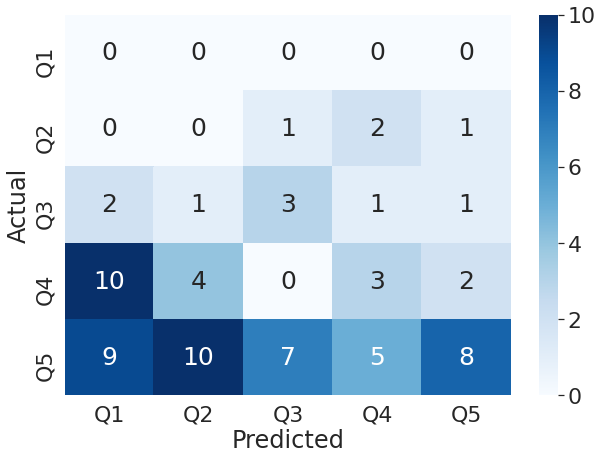

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_NNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.7)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NNI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## NNI_temp with 350 epochs

In [ ]:
# Main function to run

def train_temp_NNI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_NNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_NNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 1

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_NNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_NNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NNI_temp_std_350.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
import joblib

study.optimize(train_temp_NNI, n_trials=1)


joblib.dump(study, "./optuna_valid_NNI_drop.torch")

Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10%  	Val_kappa : -0.002  
Epoch: 2 	Training Loss:  1.609 	Train_Accu: 20%  	Valid_Acc:10%  	Val_kappa : -0.207  
Epoch: 3 	Training Loss:  1.603 	Train_Accu: 21%  	Valid_Acc:7%  	Val_kappa : -0.054  
Epoch: 4 	Training Loss:  1.602 	Train_Accu: 25%  	Valid_Acc:10%  	Val_kappa : 0.154  
Epoch: 5 	Training Loss:  1.603 	Train_Accu: 23%  	Valid_Acc:20%  	Val_kappa : 0.194  
Epoch: 6 	Training Loss:  1.597 	Train_Accu: 23%  	Valid_Acc:20%  	Val_kappa : 0.223  
Epoch: 7 	Training Loss:  1.595 	Train_Accu: 23%  	Valid_Acc:14%  	Val_kappa : -0.030  
Epoch: 8 	Training Loss:  1.557 	Train_Accu: 27%  	Valid_Acc:20%  	Val_kappa : 0.311  
Epoch: 9 	Training Loss:  1.586 	Train_Accu: 24%  	Valid_Acc:11%  	Val_kappa : 0.125  
Epoch: 10 	Training Loss:  1.549 	Train_Accu: 30%  	Valid_Acc:19%  	Val_kappa : -0.211  
Epoch: 11 	Training Loss:  1.538 	Train_Accu: 24%  	Valid_Acc:13%  	Val_kappa : -0.269  
Epoch: 12 	Training Loss:  1.557 	Tr

[I 2021-08-27 03:51:05,357] Trial 1 finished with value: 35.7 and parameters: {}. Best is trial 1 with value: 35.7.


Epoch: 350 	Training Loss:  0.434 	Train_Accu: 84%  	Valid_Acc:36%  	Val_kappa : 0.009  


['./optuna_valid_NNI_drop.torch']

## Test

tensor([1, 3, 4, 0, 4, 2, 3, 3, 2, 3, 4, 3, 3, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 3,
        0, 4, 4, 3, 1, 3, 4, 4, 3, 1, 4, 2, 3, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 3,
        1, 1, 1, 2, 3, 2, 1, 1, 0, 0, 3, 1, 0, 1, 4, 3, 2, 0, 2, 3, 1, 1])
labels tensor([1, 3, 3, 4, 4, 4, 3, 3, 2, 2, 3, 3, 4, 3, 3, 3, 2, 3, 1, 2, 2, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4])
correct : 17
test_Accuracy % : 24.3
kappa -0.02443876101165099
[[ 0  0  0  0  0]
 [ 0  1  2  0  1]
 [ 2  1  3  2  0]
 [ 2  3  5  7  2]
 [ 7 11  8  7  6]]


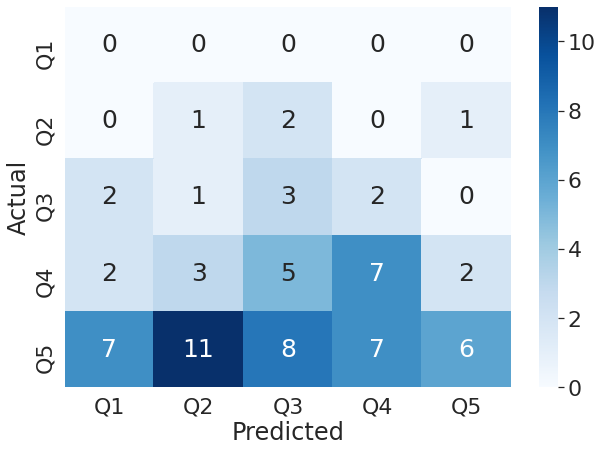

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_NNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NNI_temp_std_350.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## NSI_Temp

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_NSI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_NSI_regional_ave_time_series.csv")
Data_temp_NSI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,13.529139,3,5,1.130297,NSI
1,1981-05-01,10.664010,3,5,0.601667,NSI
2,1981-06-01,7.765787,3,4,0.311765,NSI
3,1981-07-01,5.301817,2,3,-0.244312,NSI
4,1981-08-01,4.404314,1,1,-0.486938,NSI
...,...,...,...,...,...,...
460,2019-08-01,5.154255,2,4,0.263003,NSI
461,2019-09-01,5.721869,2,3,0.095062,NSI
462,2019-10-01,6.591238,1,1,-0.577933,NSI
463,2019-11-01,8.929972,2,3,-0.018006,NSI


In [ ]:
# Extracting label column
labels_temp_NSI = Data_temp_NSI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_NSI region into tensors
labelsTensors_temp_NSI = labels_Tensors(labels_temp_NSI) # This represents y

In [ ]:
# Train lables distribution
Train_labels = labels_temp_NSI[:325]
Train_labels.value_counts()

In [ ]:
# Function to get data loader functions

def get_valid_loaders_NSI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_NSI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_NSI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )


    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_temp_NSI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NSI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_NSI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_NSI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_NSI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_NSI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NSI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')

[I 2021-08-27 03:55:09,127] A new study created in memory with name: no-name-3bcbce4e-5b70-4f87-a869-b6eaf1aa0181


In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_temp_NSI, n_trials=1)


joblib.dump(study, "optimise_valid_NSI_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.681 	Train_Accu: 21%  	Valid_Acc:10%  	Val_kappa : 0.000  
Epoch: 2 	Training Loss:  1.610 	Train_Accu: 22%  	Valid_Acc:13%  	Val_kappa : -0.224  
Epoch: 3 	Training Loss:  1.600 	Train_Accu: 23%  	Valid_Acc:11%  	Val_kappa : 0.074  
Epoch: 4 	Training Loss:  1.590 	Train_Accu: 23%  	Valid_Acc:13%  	Val_kappa : 0.245  
Epoch: 5 	Training Loss:  1.591 	Train_Accu: 25%  	Valid_Acc:23%  	Val_kappa : -0.113  
Epoch: 6 	Training Loss:  1.599 	Train_Accu: 22%  	Valid_Acc:26%  	Val_kappa : 0.217  
Epoch: 7 	Training Loss:  1.592 	Train_Accu: 25%  	Valid_Acc:14%  	Val_kappa : -0.081  
Epoch: 8 	Training Loss:  1.556 	Train_Accu: 27%  	Valid_Acc:16%  	Val_kappa : 0.298  
Epoch: 9 	Training Loss:  1.589 	Train_Accu: 25%  	Valid_Acc:24%  	Val_kappa : -0.062  
Epoch: 10 	Training Loss:  1.566 	Train_Accu: 24%  	Valid_Acc:20%  	Val_kappa : -0.612  
Epoch: 11 	Training Loss:  1.544 	Train_Accu: 31%  	Valid_Acc:14%  	Val_kappa : -0.630  
Epoch: 12 	Training Loss:  1.531 	T

[I 2021-08-27 04:01:29,574] Trial 0 finished with value: 15.7 and parameters: {}. Best is trial 0 with value: 15.7.


Epoch: 350 	Training Loss:  0.323 	Train_Accu: 87%  	Valid_Acc:16%  	Val_kappa : 0.079  


['optimise_valid_NSI_drop(0.5).torch']

### Test

tensor([1, 3, 2, 1, 2, 1, 1, 4, 1, 1, 2, 1, 1, 0, 2, 3, 1, 1, 1, 1, 2, 0, 2, 4,
        3, 2, 2, 0, 0, 1, 3, 2, 3, 2, 1, 2, 1, 3, 3, 4, 2, 2, 3, 2, 2, 1, 4, 1,
        4, 1, 3, 1, 2, 1, 3, 2, 3, 1, 3, 1, 2, 2, 2, 2, 3, 1, 2, 1, 2, 0])
labels tensor([0, 2, 3, 4, 4, 4, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 2, 2, 0, 1, 0, 1, 1, 4,
        4, 4, 4, 4, 4, 3, 2, 1, 3, 1, 0, 0, 0, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4,
        4, 3, 3, 2, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 2, 0, 2, 2])
correct : 15
test_Accuracy % : 21.4
kappa 0.20463960231980116
[[0 5 2 0 0]
 [1 2 3 0 0]
 [1 5 3 2 0]
 [1 6 7 7 2]
 [2 6 8 4 3]]


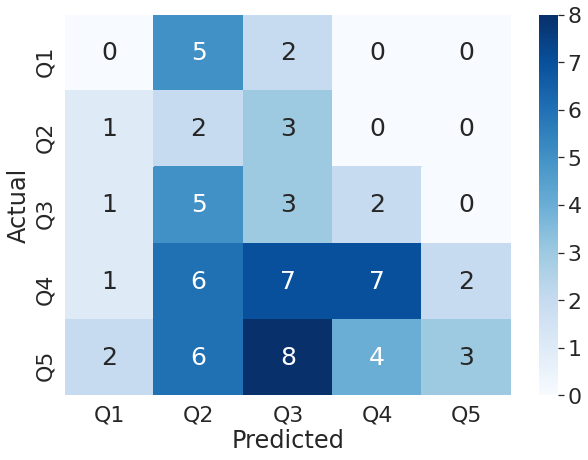

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_NSI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NSI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## WSI_temp

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_WSI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_WSI_regional_ave_time_series.csv")
Data_temp_WSI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,11.319537,3,5,0.627651,WSI
1,1981-05-01,8.644334,3,4,0.343807,WSI
2,1981-06-01,5.656854,2,3,-0.004109,WSI
3,1981-07-01,3.329886,1,2,-0.359621,WSI
4,1981-08-01,2.483252,1,1,-0.633298,WSI
...,...,...,...,...,...,...
460,2019-08-01,3.831511,3,5,0.714960,WSI
461,2019-09-01,4.440939,3,4,0.414789,WSI
462,2019-10-01,5.329010,1,2,-0.413333,WSI
463,2019-11-01,7.637988,2,3,0.054893,WSI


In [ ]:
# Extracting label column
labels_temp_WSI = Data_temp_WSI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_WSI region into tensors
labelsTensors_temp_WSI = labels_Tensors(labels_temp_WSI) # This represents y

In [ ]:
train_lab_WSI = labels_temp_WSI[:325]
train_lab_WSI.value_counts()

1    68
5    65
2    65
4    63
3    63
Name: cat_5, dtype: int64

In [ ]:
# Function to get data loader functions

def get_valid_loaders_WSI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_WSI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_WSI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_temp_WSI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_WSI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_WSI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_WSI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_WSI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_WSI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_WSI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_temp_WSI, n_trials=1)


joblib.dump(study, "optimise_valid_WSI_temp_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.710 	Train_Accu: 18%  	Valid_Acc:10%  	Val_kappa : 0.030  
Epoch: 2 	Training Loss:  1.610 	Train_Accu: 21%  	Valid_Acc:14%  	Val_kappa : 0.127  
Epoch: 3 	Training Loss:  1.605 	Train_Accu: 21%  	Valid_Acc:17%  	Val_kappa : 0.119  
Epoch: 4 	Training Loss:  1.604 	Train_Accu: 20%  	Valid_Acc:11%  	Val_kappa : 0.213  
Epoch: 5 	Training Loss:  1.595 	Train_Accu: 22%  	Valid_Acc:20%  	Val_kappa : -0.037  
Epoch: 6 	Training Loss:  1.596 	Train_Accu: 22%  	Valid_Acc:21%  	Val_kappa : 0.178  
Epoch: 7 	Training Loss:  1.591 	Train_Accu: 22%  	Valid_Acc:14%  	Val_kappa : -0.144  
Epoch: 8 	Training Loss:  1.592 	Train_Accu: 26%  	Valid_Acc:16%  	Val_kappa : 0.116  
Epoch: 9 	Training Loss:  1.586 	Train_Accu: 23%  	Valid_Acc:21%  	Val_kappa : -0.327  
Epoch: 10 	Training Loss:  1.580 	Train_Accu: 25%  	Valid_Acc:19%  	Val_kappa : 0.083  
Epoch: 11 	Training Loss:  1.554 	Train_Accu: 28%  	Valid_Acc:17%  	Val_kappa : 0.036  
Epoch: 12 	Training Loss:  1.568 	Trai

[I 2021-08-27 04:15:41,664] Trial 1 finished with value: 11.4 and parameters: {}. Best is trial 0 with value: 15.7.


Epoch: 350 	Training Loss:  0.411 	Train_Accu: 83%  	Valid_Acc:11%  	Val_kappa : -0.158  


['optimise_valid_WSI_temp_drop(0.5).torch']

### Test

tensor([2, 1, 1, 2, 2, 0, 0, 4, 4, 2, 0, 4, 2, 0, 3, 1, 2, 2, 4, 0, 0, 1, 2, 2,
        4, 4, 4, 0, 2, 1, 2, 3, 3, 3, 4, 4, 0, 2, 3, 2, 1, 3, 1, 0, 1, 1, 1, 4,
        1, 4, 4, 4, 1, 1, 3, 3, 0, 1, 1, 2, 2, 4, 4, 4, 2, 1, 2, 1, 2, 0])
labels tensor([0, 3, 3, 4, 4, 4, 2, 2, 0, 2, 3, 4, 3, 2, 3, 3, 2, 2, 1, 1, 1, 2, 2, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 0, 0, 0, 2, 3, 3, 2, 4, 4, 4, 4, 4, 4, 4,
        4, 1, 2, 1, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 2, 2])
correct : 19
test_Accuracy % : 27.1
kappa -0.04571753770274101
[[ 1  0  1  0  3]
 [ 2  1  0  0  3]
 [ 3  2  6  1  2]
 [ 2  4  3  3  0]
 [ 3 10  8  4  8]]


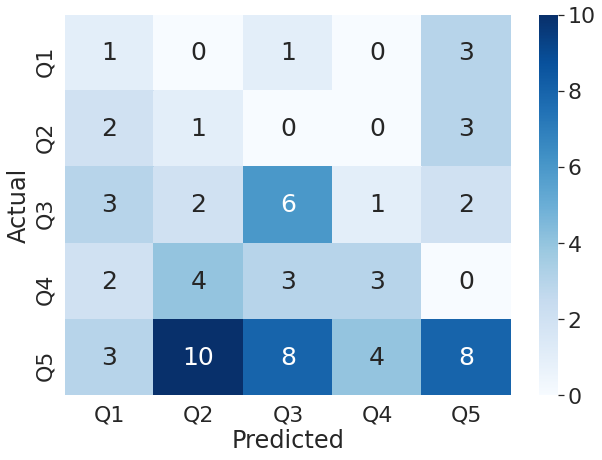

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_WSI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_WSI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## WNI_temp

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_WNI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_WNI_regional_ave_time_series.csv")
Data_temp_WNI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,15.650189,3,5,1.266127,WNI
1,1981-05-01,13.055781,3,5,0.904891,WNI
2,1981-06-01,10.325244,3,4,0.491939,WNI
3,1981-07-01,8.129155,2,3,0.003285,WNI
4,1981-08-01,7.293863,2,3,-0.132038,WNI
...,...,...,...,...,...,...
460,2019-08-01,8.151554,3,5,0.725653,WNI
461,2019-09-01,8.799411,3,5,0.831812,WNI
462,2019-10-01,9.492618,2,4,0.227855,WNI
463,2019-11-01,11.580670,3,5,0.659839,WNI


In [ ]:
# Extracting lable coulmn
labels_temp_WNI = Data_temp_WNI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_WNI region into tensors
labelsTensors_temp_WNI = labels_Tensors(labels_temp_WNI) # This represents y

In [ ]:
train_lab_WNI = labels_temp_WNI[:325]
train_lab_WNI.value_counts()

5    68
2    68
1    67
3    65
4    56
Name: cat_5, dtype: int64

In [ ]:
# Function to get data loader functions

def get_valid_loaders_WNI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_WNI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_WNI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )
   

    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_temp_WNI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_WNI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_WNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_WNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_WNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_WNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_WNI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_temp_WNI, n_trials=1)


joblib.dump(study, "optimise_valid_WNI_temp_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.691 	Train_Accu: 18%  	Valid_Acc:10%  	Val_kappa : -0.018  
Epoch: 2 	Training Loss:  1.612 	Train_Accu: 21%  	Valid_Acc:7%  	Val_kappa : 0.170  
Epoch: 3 	Training Loss:  1.605 	Train_Accu: 22%  	Valid_Acc:14%  	Val_kappa : 0.019  
Epoch: 4 	Training Loss:  1.587 	Train_Accu: 26%  	Valid_Acc:16%  	Val_kappa : 0.140  
Epoch: 5 	Training Loss:  1.602 	Train_Accu: 21%  	Valid_Acc:23%  	Val_kappa : 0.014  
Epoch: 6 	Training Loss:  1.605 	Train_Accu: 20%  	Valid_Acc:14%  	Val_kappa : 0.250  
Epoch: 7 	Training Loss:  1.597 	Train_Accu: 19%  	Valid_Acc:20%  	Val_kappa : 0.597  
Epoch: 8 	Training Loss:  1.585 	Train_Accu: 25%  	Valid_Acc:17%  	Val_kappa : 0.100  
Epoch: 9 	Training Loss:  1.585 	Train_Accu: 25%  	Valid_Acc:13%  	Val_kappa : 0.192  
Epoch: 10 	Training Loss:  1.570 	Train_Accu: 26%  	Valid_Acc:11%  	Val_kappa : -0.186  
Epoch: 11 	Training Loss:  1.556 	Train_Accu: 27%  	Valid_Acc:13%  	Val_kappa : -0.227  
Epoch: 12 	Training Loss:  1.579 	Train

[I 2021-08-27 04:21:59,879] Trial 2 finished with value: 20.0 and parameters: {}. Best is trial 2 with value: 20.0.


Epoch: 350 	Training Loss:  0.425 	Train_Accu: 85%  	Valid_Acc:20%  	Val_kappa : -0.113  


['optimise_valid_WNI_temp_drop(0.5).torch']

### Test

tensor([1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 3, 1, 1, 1, 4, 0, 0, 2, 1, 0, 1, 4, 3, 0,
        0, 0, 0, 0, 4, 2, 4, 4, 4, 1, 3, 3, 4, 2, 4, 2, 4, 0, 1, 0, 1, 2, 4, 4,
        2, 4, 4, 2, 2, 0, 2, 2, 1, 0, 1, 3, 4, 1, 3, 1, 4, 0, 1, 1, 2, 1])
labels tensor([1, 3, 4, 4, 4, 4, 2, 3, 2, 2, 3, 3, 4, 3, 4, 3, 2, 2, 1, 1, 2, 2, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 3, 4, 4, 3, 2, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 2, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 4])
correct : 18
test_Accuracy % : 25.7
kappa 0.06610911987256074
[[ 0  0  0  0  0]
 [ 1  2  0  2  0]
 [ 1  5  2  0  2]
 [ 4  7  3  2  1]
 [ 9  7  8  2 12]]


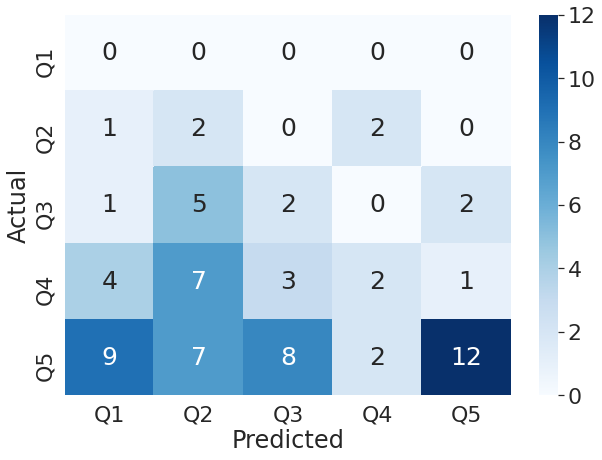

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_WNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_WNI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## ESI_temp

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_ESI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_ESI_regional_ave_time_series.csv")
Data_temp_ESI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,13.040097,3,5,0.742062,ESI
1,1981-05-01,10.122859,3,4,0.356213,ESI
2,1981-06-01,7.250265,2,4,0.288826,ESI
3,1981-07-01,4.874913,2,3,-0.008318,ESI
4,1981-08-01,3.946161,1,2,-0.369332,ESI
...,...,...,...,...,...,...
460,2019-08-01,5.151355,3,5,0.835862,ESI
461,2019-09-01,6.052051,3,5,0.675340,ESI
462,2019-10-01,7.021530,1,2,-0.274495,ESI
463,2019-11-01,9.717596,3,4,0.406646,ESI


In [ ]:
# Extracting label column
labels_temp_ESI = Data_temp_ESI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_ESI region into tensors
labelsTensors_temp_ESI = labels_Tensors(labels_temp_ESI) # This represents y

In [ ]:
train_lab_ESI = labels_temp_ESI[:324]
train_lab_ESI.value_counts()

1    67
2    66
5    65
4    64
3    62
Name: cat_5, dtype: int64

In [ ]:
# Function to get data loader functions

def get_valid_loaders_ESI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_ESI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_ESI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )


    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_temp_ESI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 350,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_ESI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_WNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_WNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 1

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_ESI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_ESI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_ESI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_temp_ESI, n_trials=1)


joblib.dump(study, "optimise_valid_ESI_temp_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.676 	Train_Accu: 24%  	Valid_Acc:10%  	Val_kappa : 0.042  
Epoch: 2 	Training Loss:  1.613 	Train_Accu: 18%  	Valid_Acc:17%  	Val_kappa : 0.086  
Epoch: 3 	Training Loss:  1.614 	Train_Accu: 19%  	Valid_Acc:16%  	Val_kappa : -0.052  
Epoch: 4 	Training Loss:  1.607 	Train_Accu: 21%  	Valid_Acc:17%  	Val_kappa : 0.045  
Epoch: 5 	Training Loss:  1.607 	Train_Accu: 23%  	Valid_Acc:16%  	Val_kappa : -0.071  
Epoch: 6 	Training Loss:  1.611 	Train_Accu: 19%  	Valid_Acc:17%  	Val_kappa : -0.024  
Epoch: 7 	Training Loss:  1.612 	Train_Accu: 21%  	Valid_Acc:20%  	Val_kappa : 0.010  
Epoch: 8 	Training Loss:  1.605 	Train_Accu: 23%  	Valid_Acc:17%  	Val_kappa : 0.102  
Epoch: 9 	Training Loss:  1.606 	Train_Accu: 26%  	Valid_Acc:20%  	Val_kappa : -0.049  
Epoch: 10 	Training Loss:  1.598 	Train_Accu: 24%  	Valid_Acc:14%  	Val_kappa : -0.043  
Epoch: 11 	Training Loss:  1.590 	Train_Accu: 25%  	Valid_Acc:13%  	Val_kappa : -0.021  
Epoch: 12 	Training Loss:  1.589 	T

[I 2021-08-27 04:50:58,528] Trial 6 finished with value: 18.6 and parameters: {}. Best is trial 2 with value: 20.0.


Epoch: 350 	Training Loss:  0.539 	Train_Accu: 79%  	Valid_Acc:19%  	Val_kappa : 0.021  


['optimise_valid_ESI_temp_drop(0.5).torch']

### Test 

tensor([3, 3, 3, 1, 3, 1, 0, 3, 3, 2, 1, 2, 1, 3, 3, 0, 2, 0, 0, 1, 0, 2, 4, 0,
        0, 0, 4, 3, 1, 0, 0, 0, 3, 3, 1, 4, 2, 4, 3, 3, 0, 1, 4, 0, 0, 4, 4, 4,
        4, 2, 2, 4, 4, 2, 4, 0, 0, 2, 3, 0, 3, 3, 0, 0, 2, 0, 4, 0, 2, 0])
labels tensor([1, 2, 2, 4, 4, 4, 3, 2, 2, 2, 3, 4, 4, 3, 4, 4, 3, 2, 1, 1, 2, 3, 2, 4,
        4, 4, 4, 4, 4, 4, 3, 2, 4, 3, 1, 1, 1, 2, 2, 1, 1, 3, 4, 4, 4, 4, 4, 4,
        4, 2, 2, 1, 3, 4, 4, 2, 2, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 3, 4])
correct : 15
test_Accuracy % : 21.4
kappa 0.0101608806096527
[[ 0  0  0  0  0]
 [ 3  2  1  2  2]
 [ 5  0  3  5  2]
 [ 3  2  4  2  1]
 [11  4  3  7  8]]


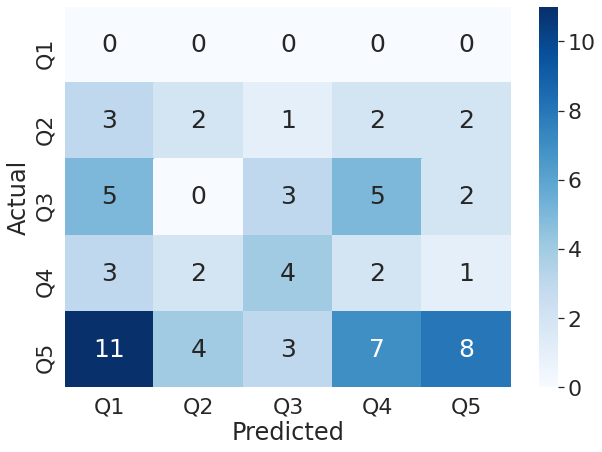

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_ESI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_ESI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

## ENI_temp

In [ ]:
# Reading rainfall file of NNI region 
Data_temp_ENI = pd.read_csv("drive/My Drive/DL_project/Target_TMean_ENI_regional_ave_time_series.csv")
Data_temp_ENI

,time,Tmean_N,cat_3,cat_5,anomalies,region
0,1981-04-01,16.006345,3,5,1.307379,ENI
1,1981-05-01,13.409171,3,5,0.959782,ENI
2,1981-06-01,10.818665,3,5,0.773066,ENI
3,1981-07-01,8.664255,3,4,0.340433,ENI
4,1981-08-01,7.825879,2,4,0.221965,ENI
...,...,...,...,...,...,...
460,2019-08-01,8.084237,3,5,0.480323,ENI
461,2019-09-01,8.767038,3,5,0.584472,ENI
462,2019-10-01,9.567420,2,3,0.019324,ENI
463,2019-11-01,11.961591,3,5,0.654974,ENI


In [ ]:
# Extracting label column
labels_temp_ENI = Data_temp_ENI['cat_5'].astype(int) #cat5 column - so 5 prediction classes 

In [ ]:
# Function that will convert labels into Pytorch tensors

def labels_Tensors(labels):
    return (torch.from_numpy(labels.values).type(torch.LongTensor)-1) #cat5 in form 1, 2, 3, 4, 5;

# Converting labels of Temp_ENI region into tensors
labelsTensors_temp_ENI = labels_Tensors(labels_temp_ENI) # This represents y

In [ ]:
train_lab_ENI = labels_temp_ENI[:324]
train_lab_ENI.value_counts()

5    71
1    65
4    64
2    63
3    61
Name: cat_5, dtype: int64

In [ ]:
# Function to get data loader functions

def get_valid_loaders_ENI_temp(Batch_size):
    """Get data loaders"""

    trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_ENI[:325])
    validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_ENI[325:395])

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=Batch_size, shuffle=False )


    return train_loader, valid_loader

In [ ]:
# Main function to run

def train_temp_ENI(trial):
  
  cfg = { 
          'Batch_size' : 1,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr'       : 0.0001,          
          'optimizer':  optim.RMSprop,
           'dropout'       : 0.8,
          'activation': F.relu}


  criterion = nn.CrossEntropyLoss()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_ENI_temp(cfg['Batch_size'])
  model = Network_dropout(cfg['dropout']).to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_temp_ENI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_temp_ENI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 1

  
  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  criterion(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = criterion(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              #print(y_pred)
              
              
             

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_temp_ENI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_temp_ENI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      

      
       

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f}  '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_ENI_temp_std.torch")
      
   
  return  round(valid_acc, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_temp_ENI, n_trials=1)


joblib.dump(study, "optimise_valid_ENI_temp_drop(0.5).torch")

Epoch: 1 	Training Loss:  1.687 	Train_Accu: 19%  	Valid_Acc:17%  	Val_kappa : -0.027  
Epoch: 2 	Training Loss:  1.611 	Train_Accu: 22%  	Valid_Acc:29%  	Val_kappa : 0.089  
Epoch: 3 	Training Loss:  1.610 	Train_Accu: 20%  	Valid_Acc:16%  	Val_kappa : -0.123  
Epoch: 4 	Training Loss:  1.596 	Train_Accu: 24%  	Valid_Acc:20%  	Val_kappa : 0.002  
Epoch: 5 	Training Loss:  1.584 	Train_Accu: 21%  	Valid_Acc:21%  	Val_kappa : 0.208  
Epoch: 6 	Training Loss:  1.625 	Train_Accu: 20%  	Valid_Acc:16%  	Val_kappa : -0.160  
Epoch: 7 	Training Loss:  1.604 	Train_Accu: 19%  	Valid_Acc:20%  	Val_kappa : -0.022  
Epoch: 8 	Training Loss:  1.582 	Train_Accu: 23%  	Valid_Acc:24%  	Val_kappa : 0.043  
Epoch: 9 	Training Loss:  1.592 	Train_Accu: 23%  	Valid_Acc:19%  	Val_kappa : 0.046  
Epoch: 10 	Training Loss:  1.583 	Train_Accu: 25%  	Valid_Acc:19%  	Val_kappa : 0.149  
Epoch: 11 	Training Loss:  1.598 	Train_Accu: 23%  	Valid_Acc:21%  	Val_kappa : 0.110  
Epoch: 12 	Training Loss:  1.579 	Tra

[I 2021-08-27 04:55:27,679] Trial 7 finished with value: 21.4 and parameters: {}. Best is trial 7 with value: 21.4.


Epoch: 250 	Training Loss:  0.539 	Train_Accu: 76%  	Valid_Acc:21%  	Val_kappa : 0.108  


['optimise_valid_ENI_temp_drop(0.5).torch']

### Test

tensor([1, 3, 4, 3, 4, 3, 1, 2, 2, 4, 1, 3, 4, 3, 4, 1, 1, 1, 2, 1, 1, 1, 3, 3,
        4, 4, 1, 4, 4, 4, 2, 3, 4, 4, 1, 4, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 2, 4,
        4, 3, 4, 3, 4, 1, 4, 4, 3, 2, 3, 1, 1, 3, 4, 1, 2, 4, 3, 2, 2, 1])
labels tensor([1, 4, 3, 4, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 2, 2, 0, 1, 1, 2, 2, 4,
        4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 2, 2, 3, 4, 3, 3, 1, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4])
correct : 27
test_Accuracy % : 38.6
kappa 0.34600158353127475
[[ 0  0  1  0  0]
 [ 0  3  1  0  0]
 [ 0  6  3  2  2]
 [ 0  3  2  8  6]
 [ 0  6  3 11 13]]


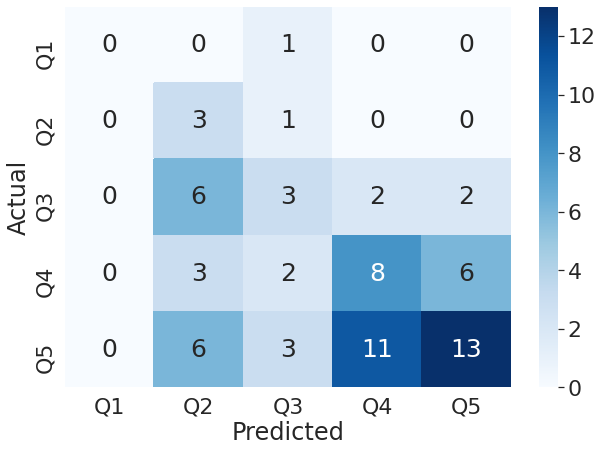

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_temp_ENI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_dropout(0.8)

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_ENI_temp_std.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()

# Rainfall models results table

In [ ]:
# Table of rainfall models results

data2 = {'Region':['NNI', 'ENI', 'WNI', 'NSI', 'ESI', 'WSI'], 'Acc_train':['99%', '98%', '98%', '99%', '99%', '99%'], 'Acc_valid':['23%', '21%', '26%', '29%', '20%', '23%'], 'Acc_test':['32%', '35%', '30%', '34%', '25%', '24%'], 'k':[0.19, 0.2, 0.03, 0.2, 0.2, 0.24 ] }
Table2 = pd.DataFrame(data2)
Table2

,Region,Acc_train,Acc_valid,Acc_test,k
0,NNI,99%,23%,32%,0.19
1,ENI,98%,21%,35%,0.20
2,WNI,98%,26%,30%,0.03
3,NSI,99%,29%,34%,0.20
4,ESI,99%,20%,25%,0.20
5,WSI,99%,23%,24%,0.24


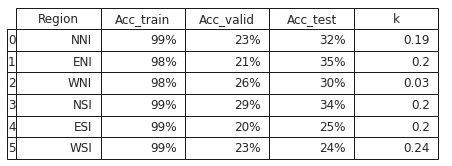

In [ ]:
# Code to plot the table to save it

from pandas.plotting import table 

fig, ax = plt.subplots(figsize=(6, 1)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, Table2, loc='upper right', colWidths=[0.14]*len(Table2.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.8, 1.8) # change size table
plt.savefig('Rain_table.png', transparent=True)

# Temperature models results table

In [ ]:
# Table of temp models results

data2 = {'Region':['NNI', 'ENI', 'WNI', 'NSI', 'ESI', 'WSI'], 'Train_Acc':['84%', '76%', '85%', '87%', '79%', '83%'], 'Valid_Acc':['36%', '21%', '20%', '24%', '29%', '20%'], 'Test_Acc':['24%', '38%', '25%', '21%', '21%', '27%'], 'k':[-0.02, 0.34, 0.06, 0.2, 0.01, -0.04 ] }
Table2 = pd.DataFrame(data2)
Table2

,Region,Train_Acc,Valid_Acc,Test_Acc,k
0,NNI,84%,36%,24%,-0.02
1,ENI,76%,21%,38%,0.34
2,WNI,85%,20%,25%,0.06
3,NSI,87%,24%,21%,0.20
4,ESI,79%,29%,21%,0.01
5,WSI,83%,20%,27%,-0.04


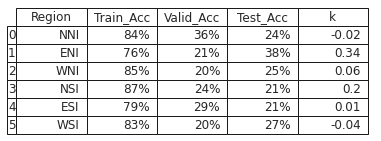

In [ ]:
# Code to plot the table to save it

from pandas.plotting import table 

fig, ax = plt.subplots(figsize=(6, 1)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, Table2, loc='upper right', colWidths=[0.14]*len(Table2.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.5, 1.5) # change size table
plt.savefig('Rain_table.png', transparent=True)

# Quadratic weighted kappa (QWK) with NNI rainfall region

This experiment has been done using continuous quadratic weighted kappa as a loss function. Custom quadratic weighted loss function is defined.

In [ ]:
# Function to calculte continous quadratic weighted kappa as loss fuction

def _one_minus_kappa_cont(prob, target, n_classes=-1):
    # All computation is on prob's device.
    #  device = prob.device
    #  target.to(device)

    if n_classes == -1:
         n_classes = prob.shape[-1]

    n_samples = torch.tensor(target.shape).prod()

  
    
    def weighted(x): return x ** 2



    # w_tq: weights centred to the correct classes, 2-dimensional tensor.
    # Dimensions of w_tq:
    #   0 - instances
    #   1 - classes

    w_tq = torch.cat([weighted(torch.arange(-t.item(), -t + n_classes))
                         .view(1, n_classes) for t in target])
   
    w_tq = w_tq
    numerator = torch.sum(w_tq * prob)

    target_histogram = torch.tensor([torch.sum(target == c) for c in range(n_classes)],
                                    dtype=torch.float) / n_samples
    target_histogram = target_histogram
    # w_ij: weights, 3-dimensional tensor sized Qx1xQ.
    # Dimensions of w_ij:
    #   0 - target classes
    #   1 - instances (defined with 1 element, to be broadcast to N)
    #   2 - prediction classes
  
    w_ij = torch.cat([weighted(torch.arange(-i, -i + n_classes))
                         .view(1, 1, n_classes)
                          for i in range(n_classes)], dim=0)
   
    w_ij = w_ij

    # The NxQ prob is unsqueezed to 1xNxQ, multiplying w_ij in Qx1xQ,
    # producing a QxNxQ result. Summing the QxNxQ along all dimensions
    # except 0, collapsing all the inner dimensions (d > 0), produces a 1-D
    # tensor of shape (Q,), each of whose elements represents the total
    # number of weighted predictions for a target class, equivalent to
    # \sum_{j=1}^Q (W_{i,j} E_{i,j}) in the non-continuous form.
    pred_per_target = torch.sum(w_ij * prob,
                                dim=list(range(1, w_ij.ndim)))
    denominator = torch.sum(pred_per_target * target_histogram)

    return numerator / denominator

This fucntion provides QWk meritc





In [ ]:
def cohen_kappa_cont(prob, target, n_classes=-1) :
    """
    Args:
        prob: Output probabilities.
        target: Targets of samples.
        n_classes: Number of classes. If not specified, compute from the length
                    of prob.
        weighting: None for unweighted, 'linear' or 'quadratic' for weighted.

    Returns:
        A scalar cohen kappa metric with specified weighting.

    """
    return torch.tensor(1.) - _one_minus_kappa_cont(prob, target, n_classes)


## Logrithm of qwk loss function

This function is used as a loss function while training



In [ ]:
def Kappaloss_log(input, target):
     prob = torch.softmax(input, dim=-1)
     one_minus_kappa = torch.log(_one_minus_kappa_cont(prob, target))
     return one_minus_kappa

## Tuning

Training NNI rainfall data with qwk loss function, RMSprop optimizer, CNN with max pooling and batch normalisation. This configuration was obtained from the paper where they introduced qwk as a loss function ( J. de la Torre , D. Puig , A. Valls , Weighted kappa loss function for multi-class classification of ordinal data in deep learning, Pattern Recogni. Lett. (2017)).

NNI rainfall model was run with quadratic weighted kappa as a loss function, batch size 10, RMSprop optimiser. Different learning rate were used to see the behaviour of the model.

In [ ]:
# Main function to run, nodropout

def train_NNI_QWK(trial):
  
  cfg = { 'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
         #'lr'       : trial.suggest_loguniform('lr', 1e-3, 1e-1),
          'lr' : trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001]),  
          'optimizer':  optim.RMSprop,     
         # 'dropout'       : trial.suggest_categorical('dropout', [0.5, 0.7,0.9 ]),
          'activation': F.relu}

 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI(cfg['Batch_size'])
  model = Network_drop_bn().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  # quad = quadratic_kappa_coefficient(output1, target1).to(device)
  # quad_metric = Qwk_metric(output1, target1).to(device)

  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  Kappaloss_log(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = Kappaloss_log(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              #print('labels', target)
              #print('pred', valid_pred)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              
              
         

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
     
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_NNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_NNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      
       #valid_qwk = Qwk_metric(fold_preds, labels_actual).item()

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "./check_valid_NNI_kappa_loss_Adam.torch")
      
   
  return  round(valid_kappa_all, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_NNI_QWK, n_trials=4)


joblib.dump(study, "drive/My Drive/DL_project/optimise_valid_NNI_temp.torch")

Epoch: 1 	Training Loss: -0.003 	Train_Accu: 21%  	Valid_Acc:20%  	Val_kappa : -0.006 
Epoch: 2 	Training Loss:  0.028 	Train_Accu: 19%  	Valid_Acc:21%  	Val_kappa : 0.096 
Epoch: 3 	Training Loss: -0.101 	Train_Accu: 22%  	Valid_Acc:20%  	Val_kappa : 0.166 
Epoch: 4 	Training Loss: -0.011 	Train_Accu: 21%  	Valid_Acc:13%  	Val_kappa : 0.007 
Epoch: 5 	Training Loss:  0.006 	Train_Accu: 17%  	Valid_Acc:24%  	Val_kappa : -0.006 
Epoch: 6 	Training Loss: -0.038 	Train_Accu: 18%  	Valid_Acc:21%  	Val_kappa : 0.065 
Epoch: 7 	Training Loss:  0.043 	Train_Accu: 22%  	Valid_Acc:19%  	Val_kappa : 0.017 
Epoch: 8 	Training Loss:  0.014 	Train_Accu: 18%  	Valid_Acc:26%  	Val_kappa : 0.000 
Epoch: 9 	Training Loss: -0.003 	Train_Accu: 20%  	Valid_Acc:33%  	Val_kappa : 0.057 
Epoch: 10 	Training Loss: -0.021 	Train_Accu: 22%  	Valid_Acc:30%  	Val_kappa : 0.023 
Epoch: 11 	Training Loss:  0.020 	Train_Accu: 22%  	Valid_Acc:23%  	Val_kappa : 0.059 
Epoch: 12 	Training Loss:  0.032 	Train_Accu: 21% 

[I 2021-08-28 00:05:57,017] Trial 0 finished with value: 0.0 and parameters: {'lr': 0.1}. Best is trial 0 with value: 0.0.


Epoch: 250 	Training Loss:  0.010 	Train_Accu: 21%  	Valid_Acc:27%  	Val_kappa : 0.018 
Epoch: 1 	Training Loss: -0.037 	Train_Accu: 20%  	Valid_Acc:33%  	Val_kappa : 0.164 
Epoch: 2 	Training Loss: -0.155 	Train_Accu: 25%  	Valid_Acc:23%  	Val_kappa : -0.084 
Epoch: 3 	Training Loss: -0.109 	Train_Accu: 22%  	Valid_Acc:19%  	Val_kappa : 0.326 
Epoch: 4 	Training Loss: -0.120 	Train_Accu: 21%  	Valid_Acc:29%  	Val_kappa : 0.256 
Epoch: 5 	Training Loss: -0.087 	Train_Accu: 22%  	Valid_Acc:30%  	Val_kappa : 0.189 
Epoch: 6 	Training Loss: -0.170 	Train_Accu: 27%  	Valid_Acc:31%  	Val_kappa : 0.258 
Epoch: 7 	Training Loss: -0.254 	Train_Accu: 25%  	Valid_Acc:26%  	Val_kappa : 0.206 
Epoch: 8 	Training Loss: -0.219 	Train_Accu: 21%  	Valid_Acc:31%  	Val_kappa : 0.131 
Epoch: 9 	Training Loss: -0.263 	Train_Accu: 22%  	Valid_Acc:31%  	Val_kappa : 0.252 
Epoch: 10 	Training Loss: -0.360 	Train_Accu: 22%  	Valid_Acc:36%  	Val_kappa : 0.196 
Epoch: 11 	Training Loss: -0.280 	Train_Accu: 22% 

[I 2021-08-28 00:07:40,938] Trial 1 finished with value: -0.0 and parameters: {'lr': 0.01}. Best is trial 0 with value: 0.0.


Epoch: 250 	Training Loss: -0.583 	Train_Accu: 32%  	Valid_Acc:7%  	Val_kappa : -0.046 
Epoch: 1 	Training Loss: -0.032 	Train_Accu: 22%  	Valid_Acc:19%  	Val_kappa : -0.030 
Epoch: 2 	Training Loss: -0.034 	Train_Accu: 21%  	Valid_Acc:19%  	Val_kappa : 0.168 
Epoch: 3 	Training Loss: -0.125 	Train_Accu: 26%  	Valid_Acc:26%  	Val_kappa : 0.162 
Epoch: 4 	Training Loss: -0.118 	Train_Accu: 25%  	Valid_Acc:24%  	Val_kappa : 0.107 
Epoch: 5 	Training Loss: -0.135 	Train_Accu: 23%  	Valid_Acc:19%  	Val_kappa : 0.006 
Epoch: 6 	Training Loss: -0.186 	Train_Accu: 26%  	Valid_Acc:23%  	Val_kappa : 0.142 
Epoch: 7 	Training Loss: -0.189 	Train_Accu: 26%  	Valid_Acc:17%  	Val_kappa : 0.215 
Epoch: 8 	Training Loss: -0.257 	Train_Accu: 27%  	Valid_Acc:19%  	Val_kappa : 0.085 
Epoch: 9 	Training Loss: -0.263 	Train_Accu: 28%  	Valid_Acc:24%  	Val_kappa : 0.179 
Epoch: 10 	Training Loss: -0.338 	Train_Accu: 30%  	Valid_Acc:29%  	Val_kappa : 0.104 
Epoch: 11 	Training Loss: -0.372 	Train_Accu: 31% 

[I 2021-08-28 00:09:27,204] Trial 2 finished with value: 0.0 and parameters: {'lr': 0.0001}. Best is trial 0 with value: 0.0.


Epoch: 250 	Training Loss: -1.547 	Train_Accu: 53%  	Valid_Acc:20%  	Val_kappa : 0.033 
Epoch: 1 	Training Loss: -0.064 	Train_Accu: 21%  	Valid_Acc:24%  	Val_kappa : -0.133 
Epoch: 2 	Training Loss:  0.002 	Train_Accu: 19%  	Valid_Acc:26%  	Val_kappa : -0.012 
Epoch: 3 	Training Loss: -0.128 	Train_Accu: 20%  	Valid_Acc:17%  	Val_kappa : -0.037 
Epoch: 4 	Training Loss: -0.066 	Train_Accu: 18%  	Valid_Acc:20%  	Val_kappa : -0.030 
Epoch: 5 	Training Loss: -0.113 	Train_Accu: 26%  	Valid_Acc:24%  	Val_kappa : 0.096 
Epoch: 6 	Training Loss: -0.109 	Train_Accu: 23%  	Valid_Acc:20%  	Val_kappa : 0.090 
Epoch: 7 	Training Loss: -0.131 	Train_Accu: 22%  	Valid_Acc:24%  	Val_kappa : 0.082 
Epoch: 8 	Training Loss: -0.202 	Train_Accu: 22%  	Valid_Acc:29%  	Val_kappa : 0.048 
Epoch: 9 	Training Loss: -0.160 	Train_Accu: 20%  	Valid_Acc:19%  	Val_kappa : -0.110 
Epoch: 10 	Training Loss: -0.123 	Train_Accu: 21%  	Valid_Acc:20%  	Val_kappa : 0.056 
Epoch: 11 	Training Loss: -0.126 	Train_Accu: 

[I 2021-08-28 00:11:10,370] Trial 3 finished with value: -0.1 and parameters: {'lr': 0.01}. Best is trial 0 with value: 0.0.


Epoch: 250 	Training Loss: -0.629 	Train_Accu: 30%  	Valid_Acc:11%  	Val_kappa : -0.112 


['drive/My Drive/DL_project/optimise_valid_NNI_temp.torch']

Training and test accuracy with different learning rate

In [ ]:
data = {  'Learning rate':[0.1, 0.01, 0.0001], 'Training_Acc':['21%', '32%', '53%'], 'Validation_Acc':['27%', '7%', '20%']  }
Table = pd.DataFrame(data)
Table

,Learning rate,Training_Acc,Validation_Acc
0,0.1000,21%,27%
1,0.0100,32%,7%
2,0.0001,53%,20%


Learnin rate 0.0001 provided the better training and test accuracy.

## NNI QWK

The model was run with the best combinations of parameters to save the model parameters and evaluated on the test dataset.

In [ ]:
# Main function to run, nodropout

def train_NNI_qwk(trial):
  
  cfg = { 'Batch_size' : 10,
          'n_epochs' : 250,
          'seed' : 32,
         'save_model' : True,
          'lr' : 0.0001,       
           'optimizer':  optim.RMSprop,
          # 'dropout'       : 0.5,
            'activation': F.relu}

 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(cfg['seed'])
  train_loader, valid_loader = get_valid_loaders_NNI(cfg['Batch_size'])
  model = Network_drop_bn().to(device)
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  # placeholders
  trainset = torch.utils.data.TensorDataset(dataTensor[:325], labelsTensors_NNI[:325])
  validset = torch.utils.data.TensorDataset(dataTensor[325:395], labelsTensors_NNI[325:395])
  fold_preds = np.zeros((len(validset), 5))

  batch_size = 10

  # quad = quadratic_kappa_coefficient(output1, target1).to(device)
  # quad_metric = Qwk_metric(output1, target1).to(device)

  
  train_accuracy = []
  valid_accuracy =[]
  train_losses =[]
  valid_losses = []
  val_kappa = []
  qwk = []
  valid_kappa = []
  valid_qwk = []
    
  for epoch in range(1, cfg['n_epochs'] + 1):
      #Valid_accuracy, train_losses, valid_losses = train_valid(cfg['log_interval'], model, train_loader, valid_loader, optimizer, epoch)
      #test_accuracy = test(model, test_loader)
       model.train()
       
       train_loss = 0
       train_correct = 0
       valid_loss = 0
       valid_correct = 0
       train_acc = 0
       valid_acc = 0
       valid_kappa_all = 0
       
    
      

       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           output_c = output.cpu()
           target_c = target.cpu()
           loss =  Kappaloss_log(output_c, target_c)
           
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           train_correct += output.argmax(dim=1).eq(target).int().sum().item()
           

       with torch.no_grad(): 
          for batch_i, (data, target) in enumerate(valid_loader): 
              data, target = data.to(device), target.to(device)         
              output = model(data)
              output_c = output.cpu()
              target_c = target.cpu()
              loss = Kappaloss_log(output_c, target_c) 
              valid_loss += loss.item()
              valid_correct += output.argmax(dim=1).eq(target).int().sum().item()
              fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = output.cpu()
              valid_pred = output.argmax(dim=1)
              #print('labels', target)
              #print('pred', valid_pred)
              
              
              y_actual = target.data.cpu().numpy()
              y_pred = valid_pred.detach().cpu().numpy()
              
              
         

        
    
       train_loss=train_loss/len(train_loader) 
       train_acc = train_correct/len(train_loader.dataset) * 100
       valid_loss = valid_loss/len(valid_loader)
       valid_acc = valid_correct/len(valid_loader.dataset)* 100
       train_accuracy.append(train_acc) 
       valid_accuracy.append(valid_acc)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
     
        
      
       fold_preds_round = fold_preds.argmax(axis = 1)
       
       y_actual_total = labelsTensors_NNI[325:395].data.cpu().numpy()
       labels_actual = labelsTensors_NNI[325:395].cpu()
      #  print(fold_preds)
      #  print(labels_actual)
       valid_kappa_all = cohen_kappa_score(y_actual_total, fold_preds_round, weights = 'quadratic')
      
       #valid_qwk = Qwk_metric(fold_preds, labels_actual).item()

   
    
       print('Epoch: {} \tTraining Loss: {: .3f} \tTrain_Accu: {:.0f}%  \tValid_Acc:{:.0f}%  \tVal_kappa : {:.3f} '.format(epoch, train_loss, train_acc, valid_acc, valid_kappa_all))  


  
       torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'train_acc':train_accuracy,
              'valid_acc':valid_accuracy,
              'train_loss':train_losses,
              'valid_loss': valid_losses
             },
              "drive/MyDrive/DL_project/check_valid_NNI_kappa_loss.torch")
      
   
  return  round(valid_kappa_all, 1)

In [ ]:
# Code to run for number of trials

from sklearn.externals import joblib

study.optimize(train_NNI_qwk, n_trials=1)


joblib.dump(study, "drive/My Drive/DL_project/optimise_valid_NNI.torch")

Epoch: 1 	Training Loss: -0.032 	Train_Accu: 22%  	Valid_Acc:19%  	Val_kappa : -0.030 
Epoch: 2 	Training Loss: -0.033 	Train_Accu: 21%  	Valid_Acc:19%  	Val_kappa : 0.205 
Epoch: 3 	Training Loss: -0.122 	Train_Accu: 26%  	Valid_Acc:26%  	Val_kappa : 0.211 
Epoch: 4 	Training Loss: -0.125 	Train_Accu: 26%  	Valid_Acc:20%  	Val_kappa : 0.054 
Epoch: 5 	Training Loss: -0.130 	Train_Accu: 21%  	Valid_Acc:20%  	Val_kappa : 0.049 
Epoch: 6 	Training Loss: -0.182 	Train_Accu: 25%  	Valid_Acc:23%  	Val_kappa : 0.183 
Epoch: 7 	Training Loss: -0.185 	Train_Accu: 28%  	Valid_Acc:16%  	Val_kappa : 0.233 
Epoch: 8 	Training Loss: -0.266 	Train_Accu: 28%  	Valid_Acc:19%  	Val_kappa : 0.157 
Epoch: 9 	Training Loss: -0.271 	Train_Accu: 28%  	Valid_Acc:24%  	Val_kappa : 0.171 
Epoch: 10 	Training Loss: -0.331 	Train_Accu: 30%  	Valid_Acc:30%  	Val_kappa : 0.114 
Epoch: 11 	Training Loss: -0.363 	Train_Accu: 30%  	Valid_Acc:23%  	Val_kappa : 0.187 
Epoch: 12 	Training Loss: -0.322 	Train_Accu: 32%  

[I 2021-08-28 00:37:08,214] Trial 9 finished with value: 0.0 and parameters: {}. Best is trial 4 with value: 0.1.


Epoch: 250 	Training Loss: -1.544 	Train_Accu: 54%  	Valid_Acc:20%  	Val_kappa : 0.022 


['drive/My Drive/DL_project/optimise_valid_NNI.torch']

## Test

tensor([2, 2, 0, 3, 1, 1, 3, 2, 1, 1, 0, 0, 4, 1, 3, 2, 0, 1, 1, 0, 0, 0, 0, 0,
        3, 3, 2, 4, 4, 4, 0, 1, 1, 1, 2, 0, 3, 4, 0, 0, 0, 1, 4, 0, 0, 0, 3, 2,
        3, 2, 4, 4, 2, 0, 2, 1, 0, 3, 1, 4, 0, 3, 2, 0, 0, 1, 2, 1, 2, 0])
labels tensor([0, 0, 0, 3, 2, 3, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
        3, 1, 1, 2, 3, 2, 2, 2, 3, 1, 0, 0, 4, 4, 4, 4, 2, 1, 3, 3, 2, 0, 1, 4,
        4, 4, 3, 3, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0])
correct : 24
test_Accuracy % : 34.3
kappa 0.3562857463272402
[[12  1  5  1  1]
 [ 3  6  3  2  0]
 [ 5  6  3  3  3]
 [ 1  2  0  2  4]
 [ 2  0  2  2  1]]


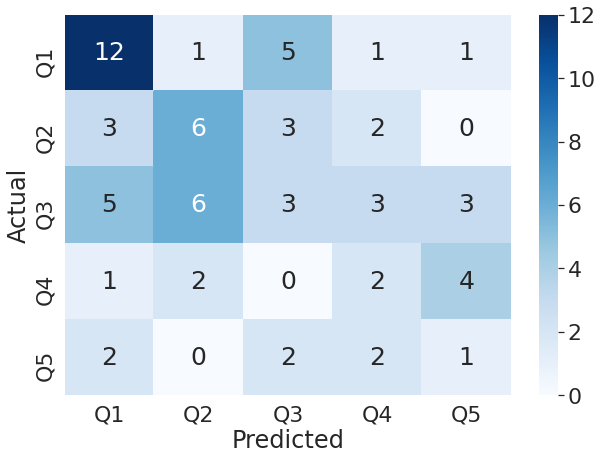

In [ ]:
# Test_set run of single dataset

#torch.manual_seed(32)

testset = torch.utils.data.TensorDataset(dataTensor[395:], labelsTensors_NNI[395:])
testloader = torch.utils.data.DataLoader(testset, batch_size=70, shuffle=False)

model = Network_drop_bn()

checkpoint = torch.load("drive/MyDrive/DL_project/check_valid_NNI_kappa_loss.torch")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#model.state_dict()





test_correct = 0
test_accuracy = 0
for images, labels in testloader:
     
     output = model(images)
     preds = output.argmax(dim=1)
     print(preds)
     print('labels', labels)
#      print('preds',preds.argmax(dim=1) )
     test_correct += output.argmax(dim=1).eq(labels).int().sum().item()

     test_accuracy = test_correct/len(testloader.dataset)*100
     
     print('correct :', test_correct )
     print("test_Accuracy % :", round(test_accuracy, 1) )
     #qwd = Qwk_metric(output, labels).item()
     #qwd_c = cohen_kappa_cont(output, labels).item()
     kappa = cohen_kappa_score(preds, labels,weights='quadratic' )
     #print('qwd', qwd)
     print('kappa', kappa)
     #print('qwd_c', qwd_c)
     #print('coff', quadratic_kappa_coefficient(preds, labels))
     #print('qua', quadratic_kappa(preds, labels))
      
     cf_matrix = confusion_matrix(labels, preds)
     print(cf_matrix)
     y_true = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     y_pred = ["Q1", "Q2", "Q3", "Q4", "Q5"]
     #data = confusion_matrix(y_true, y_pred)
     df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_true), index = np.unique(y_true))
     df_cm.index.name = 'Actual'
     df_cm.columns.name = 'Predicted'
     plt.figure(figsize = (10,7))
     sn.set(font_scale=2.0)#for label size
     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})# font size

  
     # confusionStack = torch.stack((labels, preds), dim=1)
     # confusionMatrix = torch.zeros(5, 5, dtype=torch.int64)
     # for p in confusionStack:
     #     tl, pl = p.tolist()
     #     confusionMatrix[tl, pl] = confusionMatrix[tl, pl] + 1
     # plt.figure(figsize=(10,10))
     # plot_confusion_matrix(confusionMatrix.cpu(), ('0', '1', '2', '3', '4'))
     # plt.show()